In [1]:
"""
Combined code for AMLLS project
"""
# Import
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score ,StratifiedGroupKFold , train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, make_scorer, balanced_accuracy_score, roc_curve, auc
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
import random
import lightgbm as lgb
from xgboost import XGBClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import svm
from catboost import CatBoostClassifier
import re
import pickle
import copy
import shap

# from imblearn.over_sampling import SMOTENC
# Our classes and functions
import Functions_ML_Project
import Class_ML_Project

%load_ext autoreload
%autoreload 2
%aimport

# Global variables
# Define categorical feature list
# Subset all categorical (removing the non informative medication)
CATEGORICAL = ['age','race', 'gender', 'medical_specialty', 'max_glu_serum',
               'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
               'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
               'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
               'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
               'diabetesMed', 'admission_type_descriptor', 'discharge_disposition_descriptor',
               'admission_source_descriptor']

# Define numerical feature list
NUMERICAL = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
             'number_diagnoses', 'number_outpatient', 'number_emergency', 'number_inpatient']

# Define irrelevant feature list
IRRELEVANT_FEATURES = ["payer_code",'diag_1','diag_2','diag_3','repaglinide','nateglinide','chlorpropamide','tolbutamide','acarbose','miglitol','troglitazone',
 'tolazamide','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-pioglitazone',
 'admission_source_descriptor','admission_type_id','discharge_disposition_id','admission_source_id','patient_nbr']


# Define columns for OHE
OHE_regular_cols = ['race', 'gender', 'medical_specialty', 'insulin', 'diabetesMed', 'admission_type_descriptor',
                    'discharge_disposition_descriptor']
OHE_4_to_2_cols = ['metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone']
diagnoses_cols = ['diag_1_cat', 'diag_2_cat', 'diag_3_cat']


# Define default models to initail test
models_defualt = {'Logisitic' : LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000),
          'XGBOOST' : XGBClassifier(use_label_encoder=False,random_state = 42, enable_categorical = True),
          'Tree' : DecisionTreeClassifier(random_state=42),
          'LGBM' : lgb.LGBMClassifier(random_state=42),
          'CatBoost' : CatBoostClassifier(random_seed = 42 , cat_features = ['age']),
                 'SVM': svm.SVC(kernel='linear',random_state=42, probability=True)}
random.seed(42)


# read the data file and gets train and test databases
db_train_df, db_test_df = Functions_ML_Project.clean_data_and_return_train_and_test('diabetic_data.csv')

# features pre-processing
id_names, mapping_dict = Functions_ML_Project.preform_ids_maping('IDS_mapping.csv')

# replace the disease code by disease name
training_df_new = Functions_ML_Project.apply_mapping(db_train_df, id_names, mapping_dict)

#
training_df_new = Functions_ML_Project.feature_engineering(training_df_new)


# Define the pipeline
pipeline = Pipeline([('feature_remover', Class_ML_Project.FeatureRemover(features_to_remove = IRRELEVANT_FEATURES)),
                     ('imputer_race', Class_ML_Project.DataFrameImputer(strategy='constant', fill_value='Other', columns = ['race'])),
                     ('imputer_medical', Class_ML_Project.DataFrameImputer(strategy='most_frequent',columns = ['medical_specialty'])),
                     ('age_encoder', Class_ML_Project.MultiColumnLabelEncoder(columns=['age'])),
                     ('numerical_scaler',Class_ML_Project.NumericalTransformer(columns=NUMERICAL)),
                     ('OHE', Class_ML_Project.CustomOHEncoder(OHE_regular_cols= OHE_regular_cols, OHE_4_to_2_cols=OHE_4_to_2_cols,
                       change_col='change', diag_cols=diagnoses_cols))])

# Fit and transform the DataFrame
training_clean_imputed = pipeline.fit_transform(training_df_new)
training_clean_imputed = Functions_ML_Project.remove_sparse_OHE(training_clean_imputed,OHE_regular_cols)


# Get the removed column names
removed_column_names = pipeline.named_steps['feature_remover'].features_to_remove


# Finally print the results
print("DataFrame head after feature selection and imputation:")
print(training_clean_imputed.head())
print("DataFrame shape after feature selection and imputation:")
print(training_clean_imputed.shape)

# remove readmitted above 30 days 
training_clean_imputed = training_clean_imputed[training_clean_imputed.readmitted.isin(['<30', 'NO'])]



Modules to reload:
all-except-skipped

Modules to skip:

              patient_nbr             race  gender      age weight  \
encounter_id                                                         
2278392           8222157        Caucasian  Female   [0-10)      ?   
149190           55629189        Caucasian  Female  [10-20)      ?   
64410            86047875  AfricanAmerican  Female  [20-30)      ?   
500364           82442376        Caucasian    Male  [30-40)      ?   
16680            42519267        Caucasian    Male  [40-50)      ?   

              admission_type_id  discharge_disposition_id  \
encounter_id                                                
2278392                       6                        25   
149190                        1                         1   
64410                         1                         1   
500364                        1                         1   
16680                         1                         1   

              admission_

/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:101: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  diag_count = whole_data_df[diagnosis_cols_list].apply(lambda x: x.str.contains(pattern)).sum(axis=1)




 38024 encounters out of 101766 total encounters are of diabetic patients 
 i.e. ~ 37.36% 
6836 encounters are patient repeated ones, ~17.98%

 How many pateints with their repeated encounters 
 count
1     26849
2      3091
3       750
4       242
5       114
6        55
7        31
8        14
10       10
11        9
9         7
15        4
12        2
14        2
17        2
28        1
13        1
18        1
19        1
22        1
38        1
Name: count, dtype: int64 

### Label ratios ###
____________________________
 readmitted
NO     0.547102
>30    0.343362
<30    0.109536
Name: count, dtype: float64 
____________________________

            Complete dataset  Train dataset (80%)  Test dataset (20%)
readmitted                                                           
NO                  0.547102             0.547107            0.547080
>30                 0.343362             0.343360            0.343372
<30                 0.109536             0.109533            0.10954

In [2]:
IRRELEVANT_FEATURES_for_GAN = ['repaglinide','nateglinide','chlorpropamide','tolbutamide','acarbose','miglitol','troglitazone',
 'tolazamide','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-pioglitazone',
 'admission_source_descriptor']

pipeline_GAN = Pipeline([('feature_remover', Class_ML_Project.FeatureRemover(features_to_remove = IRRELEVANT_FEATURES_for_GAN)),
                     ('imputer_race', Class_ML_Project.DataFrameImputer(strategy='constant', fill_value='Other', columns = ['race'])),
                     ('imputer_medical', Class_ML_Project.DataFrameImputer(strategy='most_frequent',columns = ['medical_specialty'])),
                     ('age_encoder', Class_ML_Project.MultiColumnLabelEncoder(columns=['age'])),
                     ('numerical_scaler',Class_ML_Project.NumericalTransformer(columns=NUMERICAL)),
                     ('OHE', Class_ML_Project.CustomOHEncoder(OHE_regular_cols= OHE_regular_cols, OHE_4_to_2_cols=OHE_4_to_2_cols,
                       change_col='change', diag_cols=diagnoses_cols))])

id_fold = pd.read_csv('id_fold.csv')

GAN_synthesized_data = [f for f in os.listdir() if 'CTGAN' in f and os.path.isfile(os.path.join(f))]

In [281]:
results_GAN_df = pd.DataFrame()
for syn_data in GAN_synthesized_data:
    fold = int(re.findall(r'\d+',syn_data)[0])
    GAN_train_fold, GAN_test_fold = Functions_ML_Project.GAN_data_preprocessing(syn_data,
                                                                                 training_clean_imputed, IRRELEVANT_FEATURES_for_GAN,
                                                                                 id_fold,OHE_regular_cols,fold,'max',pipeline_GAN)
    
    model_results = Functions_ML_Project.run_models_with_GAN(GAN_train_fold, GAN_test_fold, models = models_defualt)
    temp_df = pd.DataFrame([model_results])
    results_GAN_df = pd.concat([results_GAN_df, temp_df], ignore_index=True)
results_GAN_df.loc['mean'] = results_GAN_df.mean()
#results_GAN_df.to_csv('default_models_CT_GAN_dataframe.csv', index=True)
results_GAN_df

removed 56 sparse OHE columns

_____________
 Logisitic 
_____________



/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)



 Score.................................. = 0.581


_____________
 XGBOOST 
_____________


 Score.................................. = 0.574


_____________
 Tree 
_____________


 Score.................................. = 0.571


_____________
 LGBM 
_____________


 Score.................................. = 0.572


_____________
 CatBoost 
_____________

Learning rate set to 0.041729
0:	learn: 0.6434704	total: 29.5ms	remaining: 29.5s
1:	learn: 0.6010981	total: 56ms	remaining: 28s
2:	learn: 0.5587925	total: 87.5ms	remaining: 29.1s
3:	learn: 0.5097927	total: 110ms	remaining: 27.4s
4:	learn: 0.4754618	total: 121ms	remaining: 24.1s
5:	learn: 0.4487190	total: 131ms	remaining: 21.7s
6:	learn: 0.4292860	total: 142ms	remaining: 20.1s
7:	learn: 0.4110659	total: 153ms	remaining: 19s
8:	learn: 0.3942824	total: 165ms	remaining: 18.2s
9:	learn: 0.3778876	total: 176ms	remaining: 17.4s
10:	learn: 0.3652775	total: 186ms	remaining: 16.7s
11:	learn: 0.3536016	total: 197ms	remaining: 16.3s
12:	learn: 0

/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)



 Score.................................. = 0.580


_____________
 XGBOOST 
_____________


 Score.................................. = 0.610


_____________
 Tree 
_____________


 Score.................................. = 0.595


_____________
 LGBM 
_____________


 Score.................................. = 0.587


_____________
 CatBoost 
_____________

Learning rate set to 0.041727
0:	learn: 0.6460511	total: 38.1ms	remaining: 38.1s
1:	learn: 0.5768677	total: 71.6ms	remaining: 35.7s
2:	learn: 0.5216088	total: 96.3ms	remaining: 32s
3:	learn: 0.4937331	total: 124ms	remaining: 30.9s
4:	learn: 0.4688521	total: 136ms	remaining: 27.1s
5:	learn: 0.4462121	total: 149ms	remaining: 24.6s
6:	learn: 0.4266110	total: 161ms	remaining: 22.8s
7:	learn: 0.4084071	total: 172ms	remaining: 21.3s
8:	learn: 0.3907773	total: 183ms	remaining: 20.1s
9:	learn: 0.3781754	total: 194ms	remaining: 19.2s
10:	learn: 0.3579011	total: 203ms	remaining: 18.3s
11:	learn: 0.3480410	total: 213ms	remaining: 17.5s
12:	lear

/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)



 Score.................................. = 0.572


_____________
 XGBOOST 
_____________


 Score.................................. = 0.571


_____________
 Tree 
_____________


 Score.................................. = 0.566


_____________
 LGBM 
_____________


 Score.................................. = 0.552


_____________
 CatBoost 
_____________

Learning rate set to 0.041729
0:	learn: 0.6492569	total: 63.7ms	remaining: 1m 3s
1:	learn: 0.6084839	total: 79.4ms	remaining: 39.6s
2:	learn: 0.5460139	total: 104ms	remaining: 34.6s
3:	learn: 0.5177121	total: 121ms	remaining: 30s
4:	learn: 0.4722861	total: 132ms	remaining: 26.2s
5:	learn: 0.4424625	total: 141ms	remaining: 23.4s
6:	learn: 0.4258123	total: 151ms	remaining: 21.4s
7:	learn: 0.4001642	total: 161ms	remaining: 20s
8:	learn: 0.3846083	total: 172ms	remaining: 18.9s
9:	learn: 0.3745262	total: 182ms	remaining: 18.1s
10:	learn: 0.3565192	total: 193ms	remaining: 17.3s
11:	learn: 0.3453176	total: 203ms	remaining: 16.7s
12:	learn: 

/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)



 Score.................................. = 0.555


_____________
 XGBOOST 
_____________


 Score.................................. = 0.585


_____________
 Tree 
_____________


 Score.................................. = 0.580


_____________
 LGBM 
_____________


 Score.................................. = 0.572


_____________
 CatBoost 
_____________

Learning rate set to 0.041729
0:	learn: 0.6499227	total: 46ms	remaining: 45.9s
1:	learn: 0.6070034	total: 81.6ms	remaining: 40.7s
2:	learn: 0.5445302	total: 93.9ms	remaining: 31.2s
3:	learn: 0.4947795	total: 109ms	remaining: 27.3s
4:	learn: 0.4733600	total: 121ms	remaining: 24.1s
5:	learn: 0.4374408	total: 133ms	remaining: 22s
6:	learn: 0.4088259	total: 144ms	remaining: 20.4s
7:	learn: 0.3960754	total: 154ms	remaining: 19.1s
8:	learn: 0.3834678	total: 165ms	remaining: 18.2s
9:	learn: 0.3726263	total: 176ms	remaining: 17.4s
10:	learn: 0.3557953	total: 186ms	remaining: 16.7s
11:	learn: 0.3415030	total: 197ms	remaining: 16.2s
12:	learn:

/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)



 Score.................................. = 0.565


_____________
 XGBOOST 
_____________


 Score.................................. = 0.573


_____________
 Tree 
_____________


 Score.................................. = 0.566


_____________
 LGBM 
_____________


 Score.................................. = 0.567


_____________
 CatBoost 
_____________

Learning rate set to 0.041727
0:	learn: 0.6451016	total: 17.9ms	remaining: 17.9s
1:	learn: 0.5759564	total: 31ms	remaining: 15.5s
2:	learn: 0.5205456	total: 58.2ms	remaining: 19.3s
3:	learn: 0.4921693	total: 90.6ms	remaining: 22.6s
4:	learn: 0.4673572	total: 110ms	remaining: 21.9s
5:	learn: 0.4411627	total: 126ms	remaining: 20.9s
6:	learn: 0.4243716	total: 138ms	remaining: 19.6s
7:	learn: 0.4055006	total: 149ms	remaining: 18.5s
8:	learn: 0.3878281	total: 159ms	remaining: 17.5s
9:	learn: 0.3740940	total: 170ms	remaining: 16.8s
10:	learn: 0.3604578	total: 179ms	remaining: 16.1s
11:	learn: 0.3480132	total: 189ms	remaining: 15.5s
12:	lea

In [84]:
GAN_synthesized_data_COPULA = [f for f in os.listdir() if 'Copula' in f and os.path.isfile(os.path.join(f))]

results_GAN_df = pd.DataFrame()
for syn_data in GAN_synthesized_data_COPULA:
    fold = int(re.findall(r'\d+',syn_data)[0])
    GAN_train_fold, GAN_test_fold = Functions_ML_Project.GAN_data_preprocessing(syn_data,
                                                                                 training_clean_imputed, IRRELEVANT_FEATURES_for_GAN,
                                                                                 id_fold,OHE_regular_cols,fold,'max',pipeline_GAN)
    
    model_results = Functions_ML_Project.run_models_with_GAN(GAN_train_fold, GAN_test_fold, models = models_defualt)
    temp_df = pd.DataFrame([model_results])
    results_GAN_df = pd.concat([results_GAN_df, temp_df], ignore_index=True)
results_GAN_df.loc['mean'] = results_GAN_df.mean()
results_GAN_df.to_csv('default_models_COPULA_dataframe.csv', index=False)

removed 66 sparse OHE columns

_____________
 Logisitic 
_____________



/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)



 Score.................................. = 0.578


_____________
 XGBOOST 
_____________


 Score.................................. = 0.577


_____________
 Tree 
_____________


 Score.................................. = 0.570


_____________
 LGBM 
_____________


 Score.................................. = 0.570


_____________
 CatBoost 
_____________

Learning rate set to 0.041729


TBB Warning: The number of workers is currently limited to 9. The request for 167 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



0:	learn: 0.6417086	total: 70.6ms	remaining: 1m 10s
1:	learn: 0.5991646	total: 90.5ms	remaining: 45.2s
2:	learn: 0.5447905	total: 111ms	remaining: 37s
3:	learn: 0.5116261	total: 133ms	remaining: 33.1s
4:	learn: 0.4790094	total: 140ms	remaining: 27.9s
5:	learn: 0.4549858	total: 147ms	remaining: 24.4s
6:	learn: 0.4331157	total: 155ms	remaining: 22s
7:	learn: 0.4141406	total: 162ms	remaining: 20.1s
8:	learn: 0.3958115	total: 169ms	remaining: 18.6s
9:	learn: 0.3775663	total: 176ms	remaining: 17.4s
10:	learn: 0.3643723	total: 183ms	remaining: 16.4s
11:	learn: 0.3518179	total: 189ms	remaining: 15.6s
12:	learn: 0.3439476	total: 196ms	remaining: 14.9s
13:	learn: 0.3335822	total: 203ms	remaining: 14.3s
14:	learn: 0.3248504	total: 210ms	remaining: 13.8s
15:	learn: 0.3168208	total: 216ms	remaining: 13.3s
16:	learn: 0.3063184	total: 222ms	remaining: 12.8s
17:	learn: 0.3003991	total: 229ms	remaining: 12.5s
18:	learn: 0.2965286	total: 236ms	remaining: 12.2s
19:	learn: 0.2895534	total: 243ms	remainin

172:	learn: 0.2283038	total: 1.29s	remaining: 6.15s
173:	learn: 0.2281812	total: 1.29s	remaining: 6.14s
174:	learn: 0.2280891	total: 1.3s	remaining: 6.13s
175:	learn: 0.2279764	total: 1.31s	remaining: 6.12s
176:	learn: 0.2279032	total: 1.31s	remaining: 6.11s
177:	learn: 0.2278436	total: 1.32s	remaining: 6.09s
178:	learn: 0.2278103	total: 1.33s	remaining: 6.08s
179:	learn: 0.2277658	total: 1.33s	remaining: 6.07s
180:	learn: 0.2276261	total: 1.34s	remaining: 6.06s
181:	learn: 0.2275413	total: 1.35s	remaining: 6.05s
182:	learn: 0.2274902	total: 1.35s	remaining: 6.04s
183:	learn: 0.2274026	total: 1.36s	remaining: 6.03s
184:	learn: 0.2273801	total: 1.37s	remaining: 6.02s
185:	learn: 0.2273163	total: 1.37s	remaining: 6.01s
186:	learn: 0.2272469	total: 1.38s	remaining: 6s
187:	learn: 0.2272230	total: 1.39s	remaining: 5.99s
188:	learn: 0.2271127	total: 1.39s	remaining: 5.97s
189:	learn: 0.2270462	total: 1.4s	remaining: 5.96s
190:	learn: 0.2269708	total: 1.41s	remaining: 5.96s
191:	learn: 0.226

354:	learn: 0.2159579	total: 2.51s	remaining: 4.55s
355:	learn: 0.2158677	total: 2.51s	remaining: 4.55s
356:	learn: 0.2158465	total: 2.52s	remaining: 4.54s
357:	learn: 0.2157516	total: 2.53s	remaining: 4.53s
358:	learn: 0.2156590	total: 2.53s	remaining: 4.53s
359:	learn: 0.2156166	total: 2.54s	remaining: 4.52s
360:	learn: 0.2155519	total: 2.55s	remaining: 4.51s
361:	learn: 0.2155192	total: 2.55s	remaining: 4.5s
362:	learn: 0.2154856	total: 2.56s	remaining: 4.49s
363:	learn: 0.2154380	total: 2.57s	remaining: 4.49s
364:	learn: 0.2153427	total: 2.57s	remaining: 4.48s
365:	learn: 0.2152447	total: 2.58s	remaining: 4.47s
366:	learn: 0.2151788	total: 2.59s	remaining: 4.46s
367:	learn: 0.2151361	total: 2.6s	remaining: 4.46s
368:	learn: 0.2150542	total: 2.6s	remaining: 4.45s
369:	learn: 0.2149369	total: 2.61s	remaining: 4.44s
370:	learn: 0.2149108	total: 2.62s	remaining: 4.43s
371:	learn: 0.2148451	total: 2.62s	remaining: 4.43s
372:	learn: 0.2148244	total: 2.63s	remaining: 4.42s
373:	learn: 0.2

536:	learn: 0.2050749	total: 3.73s	remaining: 3.21s
537:	learn: 0.2050311	total: 3.74s	remaining: 3.21s
538:	learn: 0.2050098	total: 3.74s	remaining: 3.2s
539:	learn: 0.2049270	total: 3.75s	remaining: 3.19s
540:	learn: 0.2048497	total: 3.76s	remaining: 3.19s
541:	learn: 0.2047799	total: 3.76s	remaining: 3.18s
542:	learn: 0.2047062	total: 3.77s	remaining: 3.17s
543:	learn: 0.2046604	total: 3.77s	remaining: 3.16s
544:	learn: 0.2046413	total: 3.78s	remaining: 3.16s
545:	learn: 0.2045833	total: 3.79s	remaining: 3.15s
546:	learn: 0.2045271	total: 3.79s	remaining: 3.14s
547:	learn: 0.2045128	total: 3.8s	remaining: 3.13s
548:	learn: 0.2044456	total: 3.81s	remaining: 3.13s
549:	learn: 0.2043972	total: 3.81s	remaining: 3.12s
550:	learn: 0.2043051	total: 3.82s	remaining: 3.11s
551:	learn: 0.2042397	total: 3.83s	remaining: 3.11s
552:	learn: 0.2041571	total: 3.83s	remaining: 3.1s
553:	learn: 0.2041227	total: 3.84s	remaining: 3.09s
554:	learn: 0.2040552	total: 3.85s	remaining: 3.08s
555:	learn: 0.2

722:	learn: 0.1960309	total: 4.95s	remaining: 1.9s
723:	learn: 0.1959670	total: 4.96s	remaining: 1.89s
724:	learn: 0.1959482	total: 4.96s	remaining: 1.88s
725:	learn: 0.1959365	total: 4.97s	remaining: 1.88s
726:	learn: 0.1959161	total: 4.98s	remaining: 1.87s
727:	learn: 0.1958687	total: 4.99s	remaining: 1.86s
728:	learn: 0.1958513	total: 4.99s	remaining: 1.85s
729:	learn: 0.1958041	total: 5s	remaining: 1.85s
730:	learn: 0.1957510	total: 5s	remaining: 1.84s
731:	learn: 0.1957210	total: 5.01s	remaining: 1.83s
732:	learn: 0.1956334	total: 5.02s	remaining: 1.83s
733:	learn: 0.1956020	total: 5.03s	remaining: 1.82s
734:	learn: 0.1955549	total: 5.03s	remaining: 1.81s
735:	learn: 0.1954615	total: 5.04s	remaining: 1.81s
736:	learn: 0.1954069	total: 5.04s	remaining: 1.8s
737:	learn: 0.1953719	total: 5.05s	remaining: 1.79s
738:	learn: 0.1953369	total: 5.06s	remaining: 1.79s
739:	learn: 0.1953126	total: 5.07s	remaining: 1.78s
740:	learn: 0.1952726	total: 5.07s	remaining: 1.77s
741:	learn: 0.195245

900:	learn: 0.1883983	total: 6.14s	remaining: 675ms
901:	learn: 0.1883394	total: 6.15s	remaining: 668ms
902:	learn: 0.1882931	total: 6.16s	remaining: 661ms
903:	learn: 0.1882468	total: 6.16s	remaining: 655ms
904:	learn: 0.1882072	total: 6.17s	remaining: 648ms
905:	learn: 0.1881234	total: 6.18s	remaining: 641ms
906:	learn: 0.1880686	total: 6.18s	remaining: 634ms
907:	learn: 0.1879940	total: 6.19s	remaining: 627ms
908:	learn: 0.1879522	total: 6.2s	remaining: 621ms
909:	learn: 0.1879125	total: 6.21s	remaining: 614ms
910:	learn: 0.1878502	total: 6.21s	remaining: 607ms
911:	learn: 0.1878495	total: 6.22s	remaining: 600ms
912:	learn: 0.1877581	total: 6.22s	remaining: 593ms
913:	learn: 0.1877423	total: 6.23s	remaining: 586ms
914:	learn: 0.1877090	total: 6.24s	remaining: 579ms
915:	learn: 0.1876723	total: 6.24s	remaining: 573ms
916:	learn: 0.1876387	total: 6.25s	remaining: 566ms
917:	learn: 0.1875610	total: 6.26s	remaining: 559ms
918:	learn: 0.1874973	total: 6.26s	remaining: 552ms
919:	learn: 0

/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)



 Score.................................. = 0.560


_____________
 XGBOOST 
_____________


 Score.................................. = 0.601


_____________
 Tree 
_____________


 Score.................................. = 0.583


_____________
 LGBM 
_____________


 Score.................................. = 0.587


_____________
 CatBoost 
_____________

Learning rate set to 0.041727
0:	learn: 0.6263783	total: 13.7ms	remaining: 13.7s
1:	learn: 0.5888017	total: 28.8ms	remaining: 14.4s
2:	learn: 0.5508978	total: 44.4ms	remaining: 14.8s
3:	learn: 0.5158548	total: 66.9ms	remaining: 16.7s
4:	learn: 0.4689686	total: 83.7ms	remaining: 16.7s
5:	learn: 0.4437081	total: 102ms	remaining: 16.8s
6:	learn: 0.4138132	total: 120ms	remaining: 17s
7:	learn: 0.4002145	total: 136ms	remaining: 16.8s
8:	learn: 0.3847039	total: 163ms	remaining: 18s
9:	learn: 0.3646829	total: 177ms	remaining: 17.5s
10:	learn: 0.3542597	total: 185ms	remaining: 16.7s
11:	learn: 0.3454442	total: 194ms	remaining: 16s
12:	learn:

171:	learn: 0.2285855	total: 1.3s	remaining: 6.28s
172:	learn: 0.2285644	total: 1.31s	remaining: 6.27s
173:	learn: 0.2285001	total: 1.32s	remaining: 6.26s
174:	learn: 0.2284641	total: 1.32s	remaining: 6.25s
175:	learn: 0.2284025	total: 1.33s	remaining: 6.23s
176:	learn: 0.2283030	total: 1.34s	remaining: 6.22s
177:	learn: 0.2282338	total: 1.34s	remaining: 6.21s
178:	learn: 0.2281532	total: 1.35s	remaining: 6.2s
179:	learn: 0.2280920	total: 1.36s	remaining: 6.19s
180:	learn: 0.2280562	total: 1.36s	remaining: 6.18s
181:	learn: 0.2280193	total: 1.37s	remaining: 6.17s
182:	learn: 0.2279601	total: 1.38s	remaining: 6.16s
183:	learn: 0.2279044	total: 1.39s	remaining: 6.14s
184:	learn: 0.2278288	total: 1.39s	remaining: 6.13s
185:	learn: 0.2277092	total: 1.4s	remaining: 6.12s
186:	learn: 0.2276447	total: 1.41s	remaining: 6.12s
187:	learn: 0.2275942	total: 1.41s	remaining: 6.11s
188:	learn: 0.2275376	total: 1.42s	remaining: 6.09s
189:	learn: 0.2274488	total: 1.43s	remaining: 6.08s
190:	learn: 0.2

354:	learn: 0.2160925	total: 2.53s	remaining: 4.59s
355:	learn: 0.2160355	total: 2.54s	remaining: 4.59s
356:	learn: 0.2160297	total: 2.54s	remaining: 4.58s
357:	learn: 0.2159722	total: 2.55s	remaining: 4.57s
358:	learn: 0.2159403	total: 2.56s	remaining: 4.56s
359:	learn: 0.2158543	total: 2.56s	remaining: 4.55s
360:	learn: 0.2157811	total: 2.57s	remaining: 4.55s
361:	learn: 0.2157772	total: 2.58s	remaining: 4.54s
362:	learn: 0.2157557	total: 2.58s	remaining: 4.53s
363:	learn: 0.2157105	total: 2.59s	remaining: 4.52s
364:	learn: 0.2155963	total: 2.6s	remaining: 4.51s
365:	learn: 0.2155670	total: 2.6s	remaining: 4.51s
366:	learn: 0.2154560	total: 2.61s	remaining: 4.5s
367:	learn: 0.2153701	total: 2.61s	remaining: 4.49s
368:	learn: 0.2152716	total: 2.62s	remaining: 4.48s
369:	learn: 0.2151963	total: 2.63s	remaining: 4.47s
370:	learn: 0.2151517	total: 2.63s	remaining: 4.47s
371:	learn: 0.2150816	total: 2.64s	remaining: 4.46s
372:	learn: 0.2150028	total: 2.65s	remaining: 4.45s
373:	learn: 0.2

539:	learn: 0.2050397	total: 3.76s	remaining: 3.2s
540:	learn: 0.2049993	total: 3.77s	remaining: 3.2s
541:	learn: 0.2049624	total: 3.77s	remaining: 3.19s
542:	learn: 0.2049208	total: 3.78s	remaining: 3.18s
543:	learn: 0.2048678	total: 3.79s	remaining: 3.17s
544:	learn: 0.2048112	total: 3.79s	remaining: 3.17s
545:	learn: 0.2047538	total: 3.8s	remaining: 3.16s
546:	learn: 0.2046956	total: 3.81s	remaining: 3.15s
547:	learn: 0.2046810	total: 3.81s	remaining: 3.15s
548:	learn: 0.2046262	total: 3.82s	remaining: 3.14s
549:	learn: 0.2045805	total: 3.83s	remaining: 3.13s
550:	learn: 0.2045627	total: 3.83s	remaining: 3.12s
551:	learn: 0.2045004	total: 3.84s	remaining: 3.12s
552:	learn: 0.2044204	total: 3.85s	remaining: 3.11s
553:	learn: 0.2043331	total: 3.85s	remaining: 3.1s
554:	learn: 0.2042931	total: 3.86s	remaining: 3.1s
555:	learn: 0.2042402	total: 3.87s	remaining: 3.09s
556:	learn: 0.2041971	total: 3.87s	remaining: 3.08s
557:	learn: 0.2041029	total: 3.88s	remaining: 3.07s
558:	learn: 0.204

722:	learn: 0.1961766	total: 4.98s	remaining: 1.91s
723:	learn: 0.1961098	total: 4.99s	remaining: 1.9s
724:	learn: 0.1960905	total: 4.99s	remaining: 1.89s
725:	learn: 0.1960309	total: 5s	remaining: 1.89s
726:	learn: 0.1959843	total: 5.01s	remaining: 1.88s
727:	learn: 0.1959159	total: 5.01s	remaining: 1.87s
728:	learn: 0.1958572	total: 5.02s	remaining: 1.87s
729:	learn: 0.1958224	total: 5.03s	remaining: 1.86s
730:	learn: 0.1957402	total: 5.04s	remaining: 1.85s
731:	learn: 0.1956876	total: 5.04s	remaining: 1.84s
732:	learn: 0.1956630	total: 5.05s	remaining: 1.84s
733:	learn: 0.1956086	total: 5.05s	remaining: 1.83s
734:	learn: 0.1955542	total: 5.06s	remaining: 1.82s
735:	learn: 0.1955106	total: 5.07s	remaining: 1.82s
736:	learn: 0.1954828	total: 5.07s	remaining: 1.81s
737:	learn: 0.1954417	total: 5.08s	remaining: 1.8s
738:	learn: 0.1953874	total: 5.08s	remaining: 1.79s
739:	learn: 0.1953791	total: 5.09s	remaining: 1.79s
740:	learn: 0.1953447	total: 5.1s	remaining: 1.78s
741:	learn: 0.1952

905:	learn: 0.1881660	total: 6.21s	remaining: 644ms
906:	learn: 0.1881081	total: 6.21s	remaining: 637ms
907:	learn: 0.1880704	total: 6.22s	remaining: 630ms
908:	learn: 0.1880046	total: 6.22s	remaining: 623ms
909:	learn: 0.1879374	total: 6.23s	remaining: 616ms
910:	learn: 0.1878405	total: 6.24s	remaining: 610ms
911:	learn: 0.1877976	total: 6.25s	remaining: 603ms
912:	learn: 0.1877621	total: 6.25s	remaining: 596ms
913:	learn: 0.1877416	total: 6.26s	remaining: 589ms
914:	learn: 0.1876598	total: 6.27s	remaining: 582ms
915:	learn: 0.1876027	total: 6.27s	remaining: 575ms
916:	learn: 0.1875927	total: 6.28s	remaining: 568ms
917:	learn: 0.1875301	total: 6.29s	remaining: 562ms
918:	learn: 0.1874885	total: 6.29s	remaining: 555ms
919:	learn: 0.1874599	total: 6.3s	remaining: 548ms
920:	learn: 0.1874006	total: 6.3s	remaining: 541ms
921:	learn: 0.1873454	total: 6.31s	remaining: 534ms
922:	learn: 0.1873002	total: 6.32s	remaining: 527ms
923:	learn: 0.1872587	total: 6.33s	remaining: 520ms
924:	learn: 0.

/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)



 Score.................................. = 0.570


_____________
 XGBOOST 
_____________


 Score.................................. = 0.573


_____________
 Tree 
_____________


 Score.................................. = 0.569


_____________
 LGBM 
_____________


 Score.................................. = 0.566


_____________
 CatBoost 
_____________

Learning rate set to 0.041727
0:	learn: 0.6259808	total: 15ms	remaining: 14.9s
1:	learn: 0.5858488	total: 29.5ms	remaining: 14.7s
2:	learn: 0.5243349	total: 49.4ms	remaining: 16.4s
3:	learn: 0.4957245	total: 80.2ms	remaining: 20s
4:	learn: 0.4597736	total: 99.4ms	remaining: 19.8s
5:	learn: 0.4281869	total: 111ms	remaining: 18.4s
6:	learn: 0.4111044	total: 126ms	remaining: 17.9s
7:	learn: 0.3979226	total: 139ms	remaining: 17.3s
8:	learn: 0.3857120	total: 155ms	remaining: 17s
9:	learn: 0.3745386	total: 168ms	remaining: 16.7s
10:	learn: 0.3550453	total: 182ms	remaining: 16.4s
11:	learn: 0.3412606	total: 191ms	remaining: 15.7s
12:	learn:

157:	learn: 0.2286717	total: 1.3s	remaining: 6.93s
158:	learn: 0.2285883	total: 1.31s	remaining: 6.92s
159:	learn: 0.2285111	total: 1.31s	remaining: 6.91s
160:	learn: 0.2284009	total: 1.32s	remaining: 6.89s
161:	learn: 0.2283059	total: 1.33s	remaining: 6.88s
162:	learn: 0.2282098	total: 1.34s	remaining: 6.87s
163:	learn: 0.2280846	total: 1.34s	remaining: 6.86s
164:	learn: 0.2280160	total: 1.35s	remaining: 6.84s
165:	learn: 0.2279264	total: 1.36s	remaining: 6.83s
166:	learn: 0.2278738	total: 1.37s	remaining: 6.82s
167:	learn: 0.2277915	total: 1.37s	remaining: 6.8s
168:	learn: 0.2277254	total: 1.38s	remaining: 6.79s
169:	learn: 0.2276482	total: 1.39s	remaining: 6.78s
170:	learn: 0.2276140	total: 1.4s	remaining: 6.76s
171:	learn: 0.2274928	total: 1.4s	remaining: 6.75s
172:	learn: 0.2274751	total: 1.41s	remaining: 6.74s
173:	learn: 0.2274344	total: 1.42s	remaining: 6.72s
174:	learn: 0.2273713	total: 1.42s	remaining: 6.71s
175:	learn: 0.2273359	total: 1.43s	remaining: 6.7s
176:	learn: 0.227

325:	learn: 0.2166306	total: 2.53s	remaining: 5.23s
326:	learn: 0.2165894	total: 2.54s	remaining: 5.22s
327:	learn: 0.2165129	total: 2.54s	remaining: 5.21s
328:	learn: 0.2164624	total: 2.55s	remaining: 5.2s
329:	learn: 0.2164561	total: 2.56s	remaining: 5.19s
330:	learn: 0.2163527	total: 2.56s	remaining: 5.18s
331:	learn: 0.2163086	total: 2.57s	remaining: 5.18s
332:	learn: 0.2163006	total: 2.58s	remaining: 5.17s
333:	learn: 0.2162445	total: 2.59s	remaining: 5.16s
334:	learn: 0.2161813	total: 2.59s	remaining: 5.15s
335:	learn: 0.2161281	total: 2.6s	remaining: 5.14s
336:	learn: 0.2160531	total: 2.61s	remaining: 5.13s
337:	learn: 0.2159889	total: 2.62s	remaining: 5.12s
338:	learn: 0.2159813	total: 2.62s	remaining: 5.11s
339:	learn: 0.2158929	total: 2.63s	remaining: 5.11s
340:	learn: 0.2157764	total: 2.64s	remaining: 5.1s
341:	learn: 0.2157312	total: 2.65s	remaining: 5.09s
342:	learn: 0.2156990	total: 2.65s	remaining: 5.08s
343:	learn: 0.2155996	total: 2.66s	remaining: 5.07s
344:	learn: 0.2

494:	learn: 0.2073536	total: 3.76s	remaining: 3.83s
495:	learn: 0.2073326	total: 3.77s	remaining: 3.83s
496:	learn: 0.2073004	total: 3.77s	remaining: 3.82s
497:	learn: 0.2072291	total: 3.78s	remaining: 3.81s
498:	learn: 0.2071576	total: 3.79s	remaining: 3.8s
499:	learn: 0.2071561	total: 3.79s	remaining: 3.79s
500:	learn: 0.2070365	total: 3.8s	remaining: 3.79s
501:	learn: 0.2070052	total: 3.81s	remaining: 3.78s
502:	learn: 0.2069639	total: 3.82s	remaining: 3.77s
503:	learn: 0.2069080	total: 3.82s	remaining: 3.76s
504:	learn: 0.2068374	total: 3.83s	remaining: 3.76s
505:	learn: 0.2067868	total: 3.84s	remaining: 3.75s
506:	learn: 0.2067092	total: 3.85s	remaining: 3.74s
507:	learn: 0.2067068	total: 3.85s	remaining: 3.73s
508:	learn: 0.2066015	total: 3.86s	remaining: 3.73s
509:	learn: 0.2065563	total: 3.87s	remaining: 3.72s
510:	learn: 0.2064990	total: 3.88s	remaining: 3.71s
511:	learn: 0.2064422	total: 3.88s	remaining: 3.7s
512:	learn: 0.2063703	total: 3.89s	remaining: 3.69s
513:	learn: 0.2

662:	learn: 0.1990187	total: 4.99s	remaining: 2.54s
663:	learn: 0.1989799	total: 5s	remaining: 2.53s
664:	learn: 0.1989069	total: 5s	remaining: 2.52s
665:	learn: 0.1988652	total: 5.01s	remaining: 2.51s
666:	learn: 0.1987599	total: 5.02s	remaining: 2.5s
667:	learn: 0.1987094	total: 5.03s	remaining: 2.5s
668:	learn: 0.1986622	total: 5.03s	remaining: 2.49s
669:	learn: 0.1985874	total: 5.04s	remaining: 2.48s
670:	learn: 0.1985125	total: 5.05s	remaining: 2.48s
671:	learn: 0.1984466	total: 5.05s	remaining: 2.47s
672:	learn: 0.1983705	total: 5.06s	remaining: 2.46s
673:	learn: 0.1983450	total: 5.07s	remaining: 2.45s
674:	learn: 0.1982931	total: 5.08s	remaining: 2.44s
675:	learn: 0.1982341	total: 5.08s	remaining: 2.44s
676:	learn: 0.1981893	total: 5.09s	remaining: 2.43s
677:	learn: 0.1981605	total: 5.1s	remaining: 2.42s
678:	learn: 0.1980997	total: 5.11s	remaining: 2.41s
679:	learn: 0.1980603	total: 5.12s	remaining: 2.41s
680:	learn: 0.1979977	total: 5.12s	remaining: 2.4s
681:	learn: 0.1979516	

829:	learn: 0.1914284	total: 6.21s	remaining: 1.27s
830:	learn: 0.1914222	total: 6.22s	remaining: 1.26s
831:	learn: 0.1913754	total: 6.22s	remaining: 1.26s
832:	learn: 0.1913653	total: 6.23s	remaining: 1.25s
833:	learn: 0.1912973	total: 6.24s	remaining: 1.24s
834:	learn: 0.1912532	total: 6.25s	remaining: 1.23s
835:	learn: 0.1912221	total: 6.25s	remaining: 1.23s
836:	learn: 0.1912109	total: 6.26s	remaining: 1.22s
837:	learn: 0.1911399	total: 6.27s	remaining: 1.21s
838:	learn: 0.1911173	total: 6.28s	remaining: 1.2s
839:	learn: 0.1910719	total: 6.28s	remaining: 1.2s
840:	learn: 0.1910041	total: 6.29s	remaining: 1.19s
841:	learn: 0.1909726	total: 6.3s	remaining: 1.18s
842:	learn: 0.1909621	total: 6.3s	remaining: 1.17s
843:	learn: 0.1909383	total: 6.31s	remaining: 1.17s
844:	learn: 0.1908839	total: 6.32s	remaining: 1.16s
845:	learn: 0.1908596	total: 6.33s	remaining: 1.15s
846:	learn: 0.1908023	total: 6.33s	remaining: 1.14s
847:	learn: 0.1907533	total: 6.34s	remaining: 1.14s
848:	learn: 0.19

993:	learn: 0.1844732	total: 7.41s	remaining: 44.7ms
994:	learn: 0.1844426	total: 7.42s	remaining: 37.3ms
995:	learn: 0.1844206	total: 7.42s	remaining: 29.8ms
996:	learn: 0.1843828	total: 7.43s	remaining: 22.4ms
997:	learn: 0.1843408	total: 7.44s	remaining: 14.9ms
998:	learn: 0.1842627	total: 7.45s	remaining: 7.45ms
999:	learn: 0.1842063	total: 7.45s	remaining: 0us

 Score.................................. = 0.571


_____________
 SVM 
_____________


 Score.................................. = 0.555


_____________
 RandomForestClassifier 
_____________


 Score.................................. = 0.556

removed 48 sparse OHE columns

_____________
 Logisitic 
_____________



/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)



 Score.................................. = 0.551


_____________
 XGBOOST 
_____________


 Score.................................. = 0.572


_____________
 Tree 
_____________


 Score.................................. = 0.570


_____________
 LGBM 
_____________


 Score.................................. = 0.561


_____________
 CatBoost 
_____________

Learning rate set to 0.041729
0:	learn: 0.6408968	total: 12.6ms	remaining: 12.6s
1:	learn: 0.5930415	total: 27.6ms	remaining: 13.8s
2:	learn: 0.5516850	total: 37.9ms	remaining: 12.6s
3:	learn: 0.5139479	total: 51.2ms	remaining: 12.7s
4:	learn: 0.4694535	total: 64.3ms	remaining: 12.8s
5:	learn: 0.4441351	total: 88.7ms	remaining: 14.7s
6:	learn: 0.4274100	total: 107ms	remaining: 15.2s
7:	learn: 0.4088686	total: 125ms	remaining: 15.5s
8:	learn: 0.3934556	total: 137ms	remaining: 15.1s
9:	learn: 0.3795889	total: 153ms	remaining: 15.2s
10:	learn: 0.3631070	total: 167ms	remaining: 15s
11:	learn: 0.3492453	total: 178ms	remaining: 14.7s
12:	l

170:	learn: 0.2258665	total: 1.29s	remaining: 6.27s
171:	learn: 0.2257933	total: 1.3s	remaining: 6.26s
172:	learn: 0.2257562	total: 1.31s	remaining: 6.25s
173:	learn: 0.2257292	total: 1.31s	remaining: 6.24s
174:	learn: 0.2257188	total: 1.32s	remaining: 6.22s
175:	learn: 0.2256010	total: 1.33s	remaining: 6.21s
176:	learn: 0.2255663	total: 1.33s	remaining: 6.2s
177:	learn: 0.2254764	total: 1.34s	remaining: 6.19s
178:	learn: 0.2253685	total: 1.35s	remaining: 6.18s
179:	learn: 0.2252280	total: 1.35s	remaining: 6.17s
180:	learn: 0.2251612	total: 1.36s	remaining: 6.16s
181:	learn: 0.2250783	total: 1.37s	remaining: 6.15s
182:	learn: 0.2250350	total: 1.38s	remaining: 6.14s
183:	learn: 0.2249470	total: 1.38s	remaining: 6.13s
184:	learn: 0.2248673	total: 1.39s	remaining: 6.13s
185:	learn: 0.2248253	total: 1.4s	remaining: 6.12s
186:	learn: 0.2247591	total: 1.4s	remaining: 6.1s
187:	learn: 0.2246736	total: 1.41s	remaining: 6.09s
188:	learn: 0.2246277	total: 1.42s	remaining: 6.08s
189:	learn: 0.224

350:	learn: 0.2143588	total: 2.51s	remaining: 4.64s
351:	learn: 0.2143104	total: 2.52s	remaining: 4.63s
352:	learn: 0.2142506	total: 2.52s	remaining: 4.63s
353:	learn: 0.2142250	total: 2.53s	remaining: 4.62s
354:	learn: 0.2142077	total: 2.54s	remaining: 4.61s
355:	learn: 0.2141345	total: 2.54s	remaining: 4.61s
356:	learn: 0.2140499	total: 2.55s	remaining: 4.6s
357:	learn: 0.2139165	total: 2.56s	remaining: 4.59s
358:	learn: 0.2138502	total: 2.57s	remaining: 4.58s
359:	learn: 0.2137662	total: 2.57s	remaining: 4.58s
360:	learn: 0.2136671	total: 2.58s	remaining: 4.57s
361:	learn: 0.2136062	total: 2.59s	remaining: 4.56s
362:	learn: 0.2135499	total: 2.6s	remaining: 4.55s
363:	learn: 0.2134488	total: 2.6s	remaining: 4.55s
364:	learn: 0.2133846	total: 2.61s	remaining: 4.54s
365:	learn: 0.2133722	total: 2.61s	remaining: 4.53s
366:	learn: 0.2132749	total: 2.62s	remaining: 4.52s
367:	learn: 0.2132047	total: 2.63s	remaining: 4.51s
368:	learn: 0.2131024	total: 2.63s	remaining: 4.5s
369:	learn: 0.21

531:	learn: 0.2037596	total: 3.73s	remaining: 3.28s
532:	learn: 0.2036685	total: 3.74s	remaining: 3.27s
533:	learn: 0.2035917	total: 3.75s	remaining: 3.27s
534:	learn: 0.2035688	total: 3.75s	remaining: 3.26s
535:	learn: 0.2034663	total: 3.76s	remaining: 3.25s
536:	learn: 0.2033951	total: 3.77s	remaining: 3.25s
537:	learn: 0.2033378	total: 3.77s	remaining: 3.24s
538:	learn: 0.2032825	total: 3.78s	remaining: 3.23s
539:	learn: 0.2031902	total: 3.79s	remaining: 3.22s
540:	learn: 0.2031481	total: 3.79s	remaining: 3.22s
541:	learn: 0.2031116	total: 3.8s	remaining: 3.21s
542:	learn: 0.2030553	total: 3.81s	remaining: 3.2s
543:	learn: 0.2030088	total: 3.81s	remaining: 3.2s
544:	learn: 0.2029880	total: 3.82s	remaining: 3.19s
545:	learn: 0.2029577	total: 3.83s	remaining: 3.18s
546:	learn: 0.2029362	total: 3.83s	remaining: 3.17s
547:	learn: 0.2028759	total: 3.84s	remaining: 3.17s
548:	learn: 0.2028561	total: 3.85s	remaining: 3.16s
549:	learn: 0.2027931	total: 3.85s	remaining: 3.15s
550:	learn: 0.2

710:	learn: 0.1949935	total: 4.94s	remaining: 2.01s
711:	learn: 0.1949608	total: 4.95s	remaining: 2s
712:	learn: 0.1949134	total: 4.95s	remaining: 1.99s
713:	learn: 0.1948653	total: 4.96s	remaining: 1.99s
714:	learn: 0.1948192	total: 4.97s	remaining: 1.98s
715:	learn: 0.1947684	total: 4.97s	remaining: 1.97s
716:	learn: 0.1947677	total: 4.98s	remaining: 1.97s
717:	learn: 0.1947155	total: 4.99s	remaining: 1.96s
718:	learn: 0.1946934	total: 4.99s	remaining: 1.95s
719:	learn: 0.1946313	total: 5s	remaining: 1.94s
720:	learn: 0.1945835	total: 5.01s	remaining: 1.94s
721:	learn: 0.1945563	total: 5.01s	remaining: 1.93s
722:	learn: 0.1945024	total: 5.02s	remaining: 1.92s
723:	learn: 0.1944207	total: 5.03s	remaining: 1.92s
724:	learn: 0.1944181	total: 5.03s	remaining: 1.91s
725:	learn: 0.1943511	total: 5.04s	remaining: 1.9s
726:	learn: 0.1943406	total: 5.05s	remaining: 1.9s
727:	learn: 0.1942934	total: 5.05s	remaining: 1.89s
728:	learn: 0.1942764	total: 5.06s	remaining: 1.88s
729:	learn: 0.194248

886:	learn: 0.1868197	total: 6.14s	remaining: 782ms
887:	learn: 0.1868005	total: 6.14s	remaining: 775ms
888:	learn: 0.1867240	total: 6.15s	remaining: 768ms
889:	learn: 0.1866561	total: 6.16s	remaining: 761ms
890:	learn: 0.1865997	total: 6.16s	remaining: 754ms
891:	learn: 0.1865559	total: 6.17s	remaining: 747ms
892:	learn: 0.1865332	total: 6.18s	remaining: 740ms
893:	learn: 0.1864699	total: 6.18s	remaining: 733ms
894:	learn: 0.1864301	total: 6.19s	remaining: 726ms
895:	learn: 0.1863902	total: 6.2s	remaining: 720ms
896:	learn: 0.1863607	total: 6.21s	remaining: 713ms
897:	learn: 0.1863444	total: 6.21s	remaining: 706ms
898:	learn: 0.1862950	total: 6.22s	remaining: 699ms
899:	learn: 0.1862123	total: 6.22s	remaining: 692ms
900:	learn: 0.1861771	total: 6.23s	remaining: 685ms
901:	learn: 0.1861266	total: 6.24s	remaining: 678ms
902:	learn: 0.1860791	total: 6.25s	remaining: 671ms
903:	learn: 0.1860031	total: 6.25s	remaining: 664ms
904:	learn: 0.1859491	total: 6.26s	remaining: 657ms
905:	learn: 0

/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)



 Score.................................. = 0.569


_____________
 XGBOOST 
_____________


 Score.................................. = 0.581


_____________
 Tree 
_____________


 Score.................................. = 0.579


_____________
 LGBM 
_____________


 Score.................................. = 0.573


_____________
 CatBoost 
_____________

Learning rate set to 0.041729
0:	learn: 0.6256303	total: 15.3ms	remaining: 15.3s
1:	learn: 0.5741502	total: 41.7ms	remaining: 20.8s
2:	learn: 0.5398308	total: 56.5ms	remaining: 18.8s
3:	learn: 0.5098977	total: 72.2ms	remaining: 18s
4:	learn: 0.4841936	total: 85.2ms	remaining: 17s
5:	learn: 0.4443407	total: 98.8ms	remaining: 16.4s
6:	learn: 0.4226447	total: 113ms	remaining: 16s
7:	learn: 0.4043218	total: 124ms	remaining: 15.4s
8:	learn: 0.3810403	total: 137ms	remaining: 15.1s
9:	learn: 0.3676860	total: 149ms	remaining: 14.8s
10:	learn: 0.3581537	total: 159ms	remaining: 14.3s
11:	learn: 0.3427527	total: 171ms	remaining: 14.1s
12:	learn

176:	learn: 0.2282023	total: 1.3s	remaining: 6.05s
177:	learn: 0.2281179	total: 1.31s	remaining: 6.04s
178:	learn: 0.2280328	total: 1.31s	remaining: 6.03s
179:	learn: 0.2280200	total: 1.32s	remaining: 6.01s
180:	learn: 0.2279929	total: 1.33s	remaining: 6s
181:	learn: 0.2279000	total: 1.33s	remaining: 5.99s
182:	learn: 0.2278429	total: 1.34s	remaining: 5.98s
183:	learn: 0.2278281	total: 1.34s	remaining: 5.96s
184:	learn: 0.2277983	total: 1.35s	remaining: 5.95s
185:	learn: 0.2277468	total: 1.36s	remaining: 5.94s
186:	learn: 0.2276448	total: 1.36s	remaining: 5.93s
187:	learn: 0.2275815	total: 1.37s	remaining: 5.92s
188:	learn: 0.2275147	total: 1.38s	remaining: 5.91s
189:	learn: 0.2274979	total: 1.38s	remaining: 5.89s
190:	learn: 0.2274375	total: 1.39s	remaining: 5.88s
191:	learn: 0.2273436	total: 1.4s	remaining: 5.88s
192:	learn: 0.2272149	total: 1.4s	remaining: 5.87s
193:	learn: 0.2271758	total: 1.41s	remaining: 5.86s
194:	learn: 0.2270901	total: 1.42s	remaining: 5.85s
195:	learn: 0.2270

361:	learn: 0.2167376	total: 2.52s	remaining: 4.44s
362:	learn: 0.2166666	total: 2.52s	remaining: 4.43s
363:	learn: 0.2165884	total: 2.53s	remaining: 4.42s
364:	learn: 0.2165301	total: 2.54s	remaining: 4.41s
365:	learn: 0.2165178	total: 2.54s	remaining: 4.41s
366:	learn: 0.2164284	total: 2.55s	remaining: 4.4s
367:	learn: 0.2163990	total: 2.56s	remaining: 4.39s
368:	learn: 0.2163314	total: 2.56s	remaining: 4.38s
369:	learn: 0.2162961	total: 2.57s	remaining: 4.38s
370:	learn: 0.2162054	total: 2.58s	remaining: 4.37s
371:	learn: 0.2161273	total: 2.58s	remaining: 4.36s
372:	learn: 0.2160921	total: 2.59s	remaining: 4.35s
373:	learn: 0.2160872	total: 2.6s	remaining: 4.34s
374:	learn: 0.2159990	total: 2.6s	remaining: 4.34s
375:	learn: 0.2159333	total: 2.61s	remaining: 4.33s
376:	learn: 0.2158399	total: 2.62s	remaining: 4.32s
377:	learn: 0.2157596	total: 2.62s	remaining: 4.31s
378:	learn: 0.2156850	total: 2.63s	remaining: 4.31s
379:	learn: 0.2156300	total: 2.63s	remaining: 4.3s
380:	learn: 0.21

534:	learn: 0.2059927	total: 3.75s	remaining: 3.25s
535:	learn: 0.2059174	total: 3.75s	remaining: 3.25s
536:	learn: 0.2058893	total: 3.76s	remaining: 3.24s
537:	learn: 0.2058192	total: 3.77s	remaining: 3.23s
538:	learn: 0.2057462	total: 3.77s	remaining: 3.23s
539:	learn: 0.2056597	total: 3.78s	remaining: 3.22s
540:	learn: 0.2055652	total: 3.79s	remaining: 3.21s
541:	learn: 0.2055421	total: 3.8s	remaining: 3.21s
542:	learn: 0.2055140	total: 3.8s	remaining: 3.2s
543:	learn: 0.2054032	total: 3.81s	remaining: 3.19s
544:	learn: 0.2053564	total: 3.82s	remaining: 3.19s
545:	learn: 0.2053026	total: 3.83s	remaining: 3.18s
546:	learn: 0.2052420	total: 3.83s	remaining: 3.18s
547:	learn: 0.2051949	total: 3.84s	remaining: 3.17s
548:	learn: 0.2051038	total: 3.85s	remaining: 3.16s
549:	learn: 0.2050476	total: 3.86s	remaining: 3.16s
550:	learn: 0.2050252	total: 3.86s	remaining: 3.15s
551:	learn: 0.2049815	total: 3.87s	remaining: 3.14s
552:	learn: 0.2049018	total: 3.88s	remaining: 3.13s
553:	learn: 0.2

695:	learn: 0.1972205	total: 4.93s	remaining: 2.15s
696:	learn: 0.1971883	total: 4.93s	remaining: 2.15s
697:	learn: 0.1971449	total: 4.94s	remaining: 2.14s
698:	learn: 0.1971391	total: 4.95s	remaining: 2.13s
699:	learn: 0.1970657	total: 4.96s	remaining: 2.12s
700:	learn: 0.1970061	total: 4.96s	remaining: 2.12s
701:	learn: 0.1969262	total: 4.97s	remaining: 2.11s
702:	learn: 0.1968830	total: 4.98s	remaining: 2.1s
703:	learn: 0.1968811	total: 4.98s	remaining: 2.1s
704:	learn: 0.1968450	total: 4.99s	remaining: 2.09s
705:	learn: 0.1967803	total: 5s	remaining: 2.08s
706:	learn: 0.1966982	total: 5s	remaining: 2.07s
707:	learn: 0.1966555	total: 5.01s	remaining: 2.07s
708:	learn: 0.1966541	total: 5.02s	remaining: 2.06s
709:	learn: 0.1965951	total: 5.03s	remaining: 2.05s
710:	learn: 0.1964971	total: 5.04s	remaining: 2.05s
711:	learn: 0.1964573	total: 5.04s	remaining: 2.04s
712:	learn: 0.1964012	total: 5.05s	remaining: 2.03s
713:	learn: 0.1963480	total: 5.06s	remaining: 2.02s
714:	learn: 0.196296

856:	learn: 0.1893094	total: 6.11s	remaining: 1.02s
857:	learn: 0.1892684	total: 6.12s	remaining: 1.01s
858:	learn: 0.1892247	total: 6.13s	remaining: 1s
859:	learn: 0.1891802	total: 6.14s	remaining: 999ms
860:	learn: 0.1891369	total: 6.14s	remaining: 992ms
861:	learn: 0.1890862	total: 6.15s	remaining: 985ms
862:	learn: 0.1890848	total: 6.16s	remaining: 978ms
863:	learn: 0.1890335	total: 6.17s	remaining: 971ms
864:	learn: 0.1889985	total: 6.17s	remaining: 964ms
865:	learn: 0.1889089	total: 6.18s	remaining: 957ms
866:	learn: 0.1888720	total: 6.19s	remaining: 949ms
867:	learn: 0.1888503	total: 6.2s	remaining: 942ms
868:	learn: 0.1888140	total: 6.2s	remaining: 935ms
869:	learn: 0.1887671	total: 6.21s	remaining: 928ms
870:	learn: 0.1887106	total: 6.22s	remaining: 921ms
871:	learn: 0.1886536	total: 6.23s	remaining: 914ms
872:	learn: 0.1885857	total: 6.23s	remaining: 907ms
873:	learn: 0.1885692	total: 6.24s	remaining: 900ms
874:	learn: 0.1885431	total: 6.25s	remaining: 893ms
875:	learn: 0.188

In [32]:
samples_sizes = [0,0.25,0.5,0.75,'max']

params = {"objective":"binary:logistic", 'max_depth':5,
              'subsample':0.8, 'gamma':0, 'colsample_bytree':0.8,
              "seed":42, 'device':'gpu', 'tree_method': 'hist'}

best_score_after_tuning = []
baseline_scores = []
params_tuning = {}

for oversample in samples_sizes:

    all_resampled_data = []
    fold_inx =[]

    # read and process GAN data from folds 
    for syn_data in GAN_synthesized_data:
        fold = int(re.findall(r'\d+',syn_data)[0])
        GAN_train_fold, GAN_test_fold = Functions_ML_Project.GAN_data_preprocessing(syn_data,
                                                                                     training_clean_imputed, IRRELEVANT_FEATURES_for_GAN,
                                                                                     id_fold,OHE_regular_cols,fold,oversample,pipeline_GAN)
        # change indexes to unique one in each fold for hyperparameter tuning
        if len(all_resampled_data) == 0:
            GAN_train_fold.index = [row for row in range(len(GAN_train_fold))]
            GAN_test_fold.index = [row+len(GAN_train_fold) for row in range(len(GAN_test_fold))]
        else:
            GAN_train_fold.index = [row+len(all_resampled_data) for row in range(len(GAN_train_fold))]
            GAN_test_fold.index = [row+len(GAN_train_fold)+len(all_resampled_data) for row in range(len(GAN_test_fold))]

        print('train index overlap:', GAN_train_fold.index.isin(GAN_test_fold.index).sum(),'\n',
              'test index overlap:',GAN_test_fold.index.isin(GAN_train_fold.index).sum())

        index_tuple = (GAN_train_fold.index , GAN_test_fold.index)
        fold_inx.append(index_tuple)

        # comnbine all the data together fot hyperparameter tuning 
        if len(all_resampled_data) == 0:
            all_resampled_data = pd.concat([GAN_train_fold, GAN_test_fold],axis = 0)
        else:
            all_resampled_data = pd.concat([all_resampled_data,GAN_train_fold, GAN_test_fold],axis = 0)

    # tune just for size and imbalance weights
    best_value,new_params, baseline_score = Functions_ML_Project.tune_hyperparameters_XGB(objective = Functions_ML_Project.objective_tune_scale_pos_XGB,
                                                                                          base_param = params,
                                                                                         OE_data = all_resampled_data,
                                                                                         fold_index = fold_inx,
                                                                                         n_trials=100)
    best_score_after_tuning.append(best_value)
    baseline_scores.append(baseline_score)
    params_tuning[str(oversample)] = new_params

# save results 
logloss_scores_for_size_tuning = pd.DataFrame({"baseline_score" : baseline_scores,
                                               'post_tuning_score' : best_score_after_tuning}, index = samples_sizes)

logloss_scores_for_size_tuning.to_csv('sample_size_tuning_scores.csv')

with open('Sample_size_tuning_parameters.pickle', 'wb') as output_file:
                pickle.dump(params_tuning, output_file)

removed 56 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 66 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 57 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 60 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 68 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


  0%|          | 0/100 [00:00<?, ?it/s]

Best value: 0.4927546609127142, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.4920253289725708, Best params: {'scale_pos_weight': 0.7151893663724195}
Best value: 0.4920253289725708, Best params: {'scale_pos_weight': 0.7151893663724195}
Best value: 0.4920253289725708, Best params: {'scale_pos_weight': 0.7151893663724195}
Best value: 0.4920253289725708, Best params: {'scale_pos_weight': 0.7151893663724195}
Best value: 0.4920253289725708, Best params: {'scale_pos_weight': 0.7151893663724195}
Best value: 0.4920253289725708, Best params: {'scale_pos_weight': 0.7151893663724195}
Best value: 0.4920253289725708, Best params: {'scale_pos_weight': 0.7151893663724195}
Best value: 0.4920253289725708, Best params: {'scale_pos_weight': 0.7151893663724195}
Best value: 0.4920253289725708, Best params: {'scale_pos_weight': 0.7151893663724195}
Best value: 0.4920253289725708, Best params: {'scale_pos_weight': 0.7151893663724195}
Best value: 0.4920253289725708, Best params: {'scale_p

Best value: 0.49055696327465315, Best params: {'scale_pos_weight': 0.7991585642167236}
Best value: 0.49055696327465315, Best params: {'scale_pos_weight': 0.7991585642167236}
Best value: 0.49055696327465315, Best params: {'scale_pos_weight': 0.7991585642167236}
Best value: 0.49055696327465315, Best params: {'scale_pos_weight': 0.7991585642167236}
Best value: 0.49055696327465315, Best params: {'scale_pos_weight': 0.7991585642167236}
params {'objective': 'binary:logistic', 'max_depth': 5, 'subsample': 0.8, 'gamma': 0, 'colsample_bytree': 0.8, 'seed': 42, 'device': 'gpu', 'tree_method': 'hist', 'scale_pos_weight': 0.7991585642167236}
Best value 0.49055696327465315
removed 56 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 66 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 57 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 60 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 68 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


  0%|          | 0/100 [00:00<?, ?it/s]

Best value: 0.48793997148273266, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48793997148273266, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48793997148273266, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48793997148273266, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48793997148273266, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48793997148273266, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48793997148273266, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48793997148273266, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48793997148273266, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48793997148273266, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48793997148273266, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48793997148273266, Best param

Best value: 0.48793997148273266, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48793997148273266, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48793997148273266, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48793997148273266, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48793997148273266, Best params: {'scale_pos_weight': 0.5488135039273248}
params {'objective': 'binary:logistic', 'max_depth': 5, 'subsample': 0.8, 'gamma': 0, 'colsample_bytree': 0.8, 'seed': 42, 'device': 'gpu', 'tree_method': 'hist', 'scale_pos_weight': 0.5488135039273248}
Best value 0.48793997148273266
removed 56 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 66 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 57 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 60 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 68 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


  0%|          | 0/100 [00:00<?, ?it/s]

Best value: 0.49246966503964484, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48984103256367095, Best params: {'scale_pos_weight': 0.7151893663724195}
Best value: 0.48984103256367095, Best params: {'scale_pos_weight': 0.7151893663724195}
Best value: 0.48984103256367095, Best params: {'scale_pos_weight': 0.7151893663724195}
Best value: 0.48984103256367095, Best params: {'scale_pos_weight': 0.7151893663724195}
Best value: 0.48984103256367095, Best params: {'scale_pos_weight': 0.7151893663724195}
Best value: 0.48984103256367095, Best params: {'scale_pos_weight': 0.7151893663724195}
Best value: 0.48984103256367095, Best params: {'scale_pos_weight': 0.7151893663724195}
Best value: 0.48984103256367095, Best params: {'scale_pos_weight': 0.7151893663724195}
Best value: 0.48984103256367095, Best params: {'scale_pos_weight': 0.7151893663724195}
Best value: 0.48984103256367095, Best params: {'scale_pos_weight': 0.7151893663724195}
Best value: 0.48984103256367095, Best param

Best value: 0.48897072958437643, Best params: {'scale_pos_weight': 0.7163272041185655}
Best value: 0.48897072958437643, Best params: {'scale_pos_weight': 0.7163272041185655}
Best value: 0.48897072958437643, Best params: {'scale_pos_weight': 0.7163272041185655}
Best value: 0.48897072958437643, Best params: {'scale_pos_weight': 0.7163272041185655}
params {'objective': 'binary:logistic', 'max_depth': 5, 'subsample': 0.8, 'gamma': 0, 'colsample_bytree': 0.8, 'seed': 42, 'device': 'gpu', 'tree_method': 'hist', 'scale_pos_weight': 0.7163272041185655}
Best value 0.48897072958437643
removed 56 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 66 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 57 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 60 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 68 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


  0%|          | 0/100 [00:00<?, ?it/s]

Best value: 0.48949086482460746, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48949086482460746, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48949086482460746, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48949086482460746, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48949086482460746, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48949086482460746, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48949086482460746, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48949086482460746, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48949086482460746, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48949086482460746, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48949086482460746, Best params: {'scale_pos_weight': 0.5488135039273248}
Best value: 0.48949086482460746, Best param

Best value: 0.4859662944406063, Best params: {'scale_pos_weight': 0.8700121482468192}
Best value: 0.4859662944406063, Best params: {'scale_pos_weight': 0.8700121482468192}
Best value: 0.4859662944406063, Best params: {'scale_pos_weight': 0.8700121482468192}
Best value: 0.4859662944406063, Best params: {'scale_pos_weight': 0.8700121482468192}
params {'objective': 'binary:logistic', 'max_depth': 5, 'subsample': 0.8, 'gamma': 0, 'colsample_bytree': 0.8, 'seed': 42, 'device': 'gpu', 'tree_method': 'hist', 'scale_pos_weight': 0.8700121482468192}
Best value 0.4859662944406063
removed 56 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 66 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 57 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 60 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 68 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


in if


In [33]:
logloss_scores_for_size_tuning

,baseline_score,post_tuning_score
0,0.396378,0.490557
0.25,0.401599,0.487940
0.5,0.425823,0.488971
0.75,0.407658,0.485966
max,0.401137,NaN


In [3]:
params = {"objective":"binary:logistic", 'max_depth':5,
              'subsample':0.8, 'gamma':0, 'colsample_bytree':0.8,
              "seed":42, 'device':'gpu', 'tree_method': 'hist'}

all_resampled_data = []
fold_inx =[]

    # read and process GAN data from folds 
for syn_data in GAN_synthesized_data:
    fold = int(re.findall(r'\d+',syn_data)[0])
    GAN_train_fold, GAN_test_fold = Functions_ML_Project.GAN_data_preprocessing(syn_data,
                                                                                 training_clean_imputed,
                                                                                IRRELEVANT_FEATURES_for_GAN,
                                                                                 id_fold,OHE_regular_cols,fold,'max',pipeline_GAN)
    # change indexes to unique one in each fold for hyperparameter tuning
    if len(all_resampled_data):
        GAN_train_fold.index = [row for row in range(len(GAN_train_fold))]
        GAN_test_fold.index = [row+len(GAN_train_fold) for row in range(len(GAN_test_fold))]
    else:
        GAN_train_fold.index = [row+len(all_resampled_data) for row in range(len(GAN_train_fold))]
        GAN_test_fold.index = [row+len(GAN_train_fold)+len(all_resampled_data) for row in range(len(GAN_test_fold))]

    print('train index overlap:', GAN_train_fold.index.isin(GAN_test_fold.index).sum(),'\n',
          'test index overlap:',GAN_test_fold.index.isin(GAN_train_fold.index).sum())

    index_tuple = (GAN_train_fold.index , GAN_test_fold.index)
    fold_inx.append(index_tuple)

    # comnbine all the data together fot hyperparameter tuning 
    if len(all_resampled_data) == 0:
        all_resampled_data = pd.concat([GAN_train_fold, GAN_test_fold],axis = 0)
    else:
        all_resampled_data = pd.concat([all_resampled_data,GAN_train_fold, GAN_test_fold],axis = 0)


removed 56 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:402: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 66 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:402: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 57 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:402: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 60 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:402: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


removed 68 sparse OHE columns
train index overlap: 0 
 test index overlap: 0


/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train.readmitted = LabelEncoder().fit_transform(subset_train.readmitted)
/home/labs/hornsteinlab/yahelc/AMLLS/Functions_ML_Project.py:402: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test.readmitted = LabelEncoder().fit_transform(subset_test.readmitted)


In [4]:
tuned_xgboost_score, xgb_best_param, baseline_score = Functions_ML_Project.tune_hyperparameters_XGB(objective = Functions_ML_Project.objective_tune_stage_1,
                                                                                                    base_param = params,
                                                                                                    OE_data = all_resampled_data,
                                                                                                    fold_index = fold_inx,
                                                                                                    n_trials=200,
                                                                                                    tune_steps = 'two')
# with open('XGBOOST_tuned_parameters.pickle', 'wb') as output_file:
#                  pickle.dump(tuned_params, output_file)

  0%|          | 0/200 [00:00<?, ?it/s]

Best value: 0.3916121001857248, Best params: {'num_estimators': 877, 'max_depth': 6, 'learning_rate': 0.01580829012821493, 'subsample': 0.3544883182996897, 'gamma': 1.7118273996694524}
Best value: 0.39034478937215966, Best params: {'num_estimators': 882, 'max_depth': 5, 'learning_rate': 0.016675319002346242, 'subsample': 0.39636627605010294, 'gamma': 1.691720759412889}
Best value: 0.39034478937215966, Best params: {'num_estimators': 882, 'max_depth': 5, 'learning_rate': 0.016675319002346242, 'subsample': 0.39636627605010294, 'gamma': 1.691720759412889}
Best value: 0.39034478937215966, Best params: {'num_estimators': 882, 'max_depth': 5, 'learning_rate': 0.016675319002346242, 'subsample': 0.39636627605010294, 'gamma': 1.691720759412889}
Best value: 0.39034478937215966, Best params: {'num_estimators': 882, 'max_depth': 5, 'learning_rate': 0.016675319002346242, 'subsample': 0.39636627605010294, 'gamma': 1.691720759412889}
Best value: 0.39001262814708554, Best params: {'num_estimators': 88

Best value: 0.38971495050321425, Best params: {'num_estimators': 885, 'max_depth': 4, 'learning_rate': 0.016758447841234023, 'subsample': 0.37142412995491114, 'gamma': 1.9994235032839334}
Best value: 0.38971495050321425, Best params: {'num_estimators': 885, 'max_depth': 4, 'learning_rate': 0.016758447841234023, 'subsample': 0.37142412995491114, 'gamma': 1.9994235032839334}
Best value: 0.38971495050321425, Best params: {'num_estimators': 885, 'max_depth': 4, 'learning_rate': 0.016758447841234023, 'subsample': 0.37142412995491114, 'gamma': 1.9994235032839334}
Best value: 0.38971495050321425, Best params: {'num_estimators': 885, 'max_depth': 4, 'learning_rate': 0.016758447841234023, 'subsample': 0.37142412995491114, 'gamma': 1.9994235032839334}
Best value: 0.38971495050321425, Best params: {'num_estimators': 885, 'max_depth': 4, 'learning_rate': 0.016758447841234023, 'subsample': 0.37142412995491114, 'gamma': 1.9994235032839334}
Best value: 0.38971495050321425, Best params: {'num_estimato

Best value: 0.38971495050321425, Best params: {'num_estimators': 885, 'max_depth': 4, 'learning_rate': 0.016758447841234023, 'subsample': 0.37142412995491114, 'gamma': 1.9994235032839334}
Best value: 0.38971495050321425, Best params: {'num_estimators': 885, 'max_depth': 4, 'learning_rate': 0.016758447841234023, 'subsample': 0.37142412995491114, 'gamma': 1.9994235032839334}
Best value: 0.38971495050321425, Best params: {'num_estimators': 885, 'max_depth': 4, 'learning_rate': 0.016758447841234023, 'subsample': 0.37142412995491114, 'gamma': 1.9994235032839334}
Best value: 0.38971495050321425, Best params: {'num_estimators': 885, 'max_depth': 4, 'learning_rate': 0.016758447841234023, 'subsample': 0.37142412995491114, 'gamma': 1.9994235032839334}
Best value: 0.38971495050321425, Best params: {'num_estimators': 885, 'max_depth': 4, 'learning_rate': 0.016758447841234023, 'subsample': 0.37142412995491114, 'gamma': 1.9994235032839334}
Best value: 0.38971495050321425, Best params: {'num_estimato

Best value: 0.38971495050321425, Best params: {'num_estimators': 885, 'max_depth': 4, 'learning_rate': 0.016758447841234023, 'subsample': 0.37142412995491114, 'gamma': 1.9994235032839334}
Best value: 0.38971495050321425, Best params: {'num_estimators': 885, 'max_depth': 4, 'learning_rate': 0.016758447841234023, 'subsample': 0.37142412995491114, 'gamma': 1.9994235032839334}
Best value: 0.38971495050321425, Best params: {'num_estimators': 885, 'max_depth': 4, 'learning_rate': 0.016758447841234023, 'subsample': 0.37142412995491114, 'gamma': 1.9994235032839334}
Best value: 0.38971495050321425, Best params: {'num_estimators': 885, 'max_depth': 4, 'learning_rate': 0.016758447841234023, 'subsample': 0.37142412995491114, 'gamma': 1.9994235032839334}
Best value: 0.38971495050321425, Best params: {'num_estimators': 885, 'max_depth': 4, 'learning_rate': 0.016758447841234023, 'subsample': 0.37142412995491114, 'gamma': 1.9994235032839334}
Best value: 0.38971495050321425, Best params: {'num_estimato

Best value: 0.38971495050321425, Best params: {'num_estimators': 885, 'max_depth': 4, 'learning_rate': 0.016758447841234023, 'subsample': 0.37142412995491114, 'gamma': 1.9994235032839334}
Best value: 0.38971495050321425, Best params: {'num_estimators': 885, 'max_depth': 4, 'learning_rate': 0.016758447841234023, 'subsample': 0.37142412995491114, 'gamma': 1.9994235032839334}
Best value: 0.38971495050321425, Best params: {'num_estimators': 885, 'max_depth': 4, 'learning_rate': 0.016758447841234023, 'subsample': 0.37142412995491114, 'gamma': 1.9994235032839334}
Best value: 0.38971495050321425, Best params: {'num_estimators': 885, 'max_depth': 4, 'learning_rate': 0.016758447841234023, 'subsample': 0.37142412995491114, 'gamma': 1.9994235032839334}
Best value: 0.38971495050321425, Best params: {'num_estimators': 885, 'max_depth': 4, 'learning_rate': 0.016758447841234023, 'subsample': 0.37142412995491114, 'gamma': 1.9994235032839334}
Best value: 0.38971495050321425, Best params: {'num_estimato

  0%|          | 0/200 [00:00<?, ?it/s]

Best value: 0.3907203450162403, Best params: {'min_child_weight': 7, 'lambda': 0.07145568099117258, 'alpha': 0.7102763376071644, 'colsample_bytree': 0.8544883182996897, 'colsample_bynode': 0.9769461919735561, 'max_delta_step': 12, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel': 0.7875174422525385, 'max_leaves': 39}
Best value: 0.3907203450162403, Best params: {'min_child_weight': 7, 'lambda': 0.07145568099117258, 'alpha': 0.7102763376071644, 'colsample_bytree': 0.8544883182996897, 'colsample_bynode': 0.9769461919735561, 'max_delta_step': 12, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel': 0.7875174422525385, 'max_leaves': 39}
Best value: 0.39035302263093874, Best params: {'min_child_weight': 5, 'lambda': 0.07497859536643814, 'alpha': 0.727815675094985, 'colsample_bytree': 0.887001214824682, 'colsample_bynode': 0.9991447336893106, 'max_delta_step': 13, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylev

Best value: 0.3901059707171756, Best params: {'min_child_weight': 7, 'lambda': 0.05060322638562481, 'alpha': 0.7328940029217363, 'colsample_bytree': 0.8004695476192547, 'colsample_bynode': 0.9871126614718492, 'max_delta_step': 7, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel': 0.847038804424519, 'max_leaves': 40}
Best value: 0.3901059707171756, Best params: {'min_child_weight': 7, 'lambda': 0.05060322638562481, 'alpha': 0.7328940029217363, 'colsample_bytree': 0.8004695476192547, 'colsample_bynode': 0.9871126614718492, 'max_delta_step': 7, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel': 0.847038804424519, 'max_leaves': 40}
Best value: 0.3901059707171756, Best params: {'min_child_weight': 7, 'lambda': 0.05060322638562481, 'alpha': 0.7328940029217363, 'colsample_bytree': 0.8004695476192547, 'colsample_bynode': 0.9871126614718492, 'max_delta_step': 7, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel':

Best value: 0.3901059707171756, Best params: {'min_child_weight': 7, 'lambda': 0.05060322638562481, 'alpha': 0.7328940029217363, 'colsample_bytree': 0.8004695476192547, 'colsample_bynode': 0.9871126614718492, 'max_delta_step': 7, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel': 0.847038804424519, 'max_leaves': 40}
Best value: 0.3901059707171756, Best params: {'min_child_weight': 7, 'lambda': 0.05060322638562481, 'alpha': 0.7328940029217363, 'colsample_bytree': 0.8004695476192547, 'colsample_bynode': 0.9871126614718492, 'max_delta_step': 7, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel': 0.847038804424519, 'max_leaves': 40}
Best value: 0.3901059707171756, Best params: {'min_child_weight': 7, 'lambda': 0.05060322638562481, 'alpha': 0.7328940029217363, 'colsample_bytree': 0.8004695476192547, 'colsample_bynode': 0.9871126614718492, 'max_delta_step': 7, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel':

Best value: 0.3901059707171756, Best params: {'min_child_weight': 7, 'lambda': 0.05060322638562481, 'alpha': 0.7328940029217363, 'colsample_bytree': 0.8004695476192547, 'colsample_bynode': 0.9871126614718492, 'max_delta_step': 7, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel': 0.847038804424519, 'max_leaves': 40}
Best value: 0.3901059707171756, Best params: {'min_child_weight': 7, 'lambda': 0.05060322638562481, 'alpha': 0.7328940029217363, 'colsample_bytree': 0.8004695476192547, 'colsample_bynode': 0.9871126614718492, 'max_delta_step': 7, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel': 0.847038804424519, 'max_leaves': 40}
Best value: 0.3901059707171756, Best params: {'min_child_weight': 7, 'lambda': 0.05060322638562481, 'alpha': 0.7328940029217363, 'colsample_bytree': 0.8004695476192547, 'colsample_bynode': 0.9871126614718492, 'max_delta_step': 7, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel':

Best value: 0.3901059707171756, Best params: {'min_child_weight': 7, 'lambda': 0.05060322638562481, 'alpha': 0.7328940029217363, 'colsample_bytree': 0.8004695476192547, 'colsample_bynode': 0.9871126614718492, 'max_delta_step': 7, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel': 0.847038804424519, 'max_leaves': 40}
Best value: 0.3901059707171756, Best params: {'min_child_weight': 7, 'lambda': 0.05060322638562481, 'alpha': 0.7328940029217363, 'colsample_bytree': 0.8004695476192547, 'colsample_bynode': 0.9871126614718492, 'max_delta_step': 7, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel': 0.847038804424519, 'max_leaves': 40}
Best value: 0.3900196319136244, Best params: {'min_child_weight': 5, 'lambda': 0.05469150046603889, 'alpha': 0.6804198691599408, 'colsample_bytree': 0.8075359069083341, 'colsample_bynode': 0.9769865201136237, 'max_delta_step': 6, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel':

Best value: 0.3900196319136244, Best params: {'min_child_weight': 5, 'lambda': 0.05469150046603889, 'alpha': 0.6804198691599408, 'colsample_bytree': 0.8075359069083341, 'colsample_bynode': 0.9769865201136237, 'max_delta_step': 6, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel': 0.813643518733969, 'max_leaves': 28}
Best value: 0.3900196319136244, Best params: {'min_child_weight': 5, 'lambda': 0.05469150046603889, 'alpha': 0.6804198691599408, 'colsample_bytree': 0.8075359069083341, 'colsample_bynode': 0.9769865201136237, 'max_delta_step': 6, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel': 0.813643518733969, 'max_leaves': 28}
Best value: 0.3900196319136244, Best params: {'min_child_weight': 5, 'lambda': 0.05469150046603889, 'alpha': 0.6804198691599408, 'colsample_bytree': 0.8075359069083341, 'colsample_bynode': 0.9769865201136237, 'max_delta_step': 6, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel':

Best value: 0.3900196319136244, Best params: {'min_child_weight': 5, 'lambda': 0.05469150046603889, 'alpha': 0.6804198691599408, 'colsample_bytree': 0.8075359069083341, 'colsample_bynode': 0.9769865201136237, 'max_delta_step': 6, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel': 0.813643518733969, 'max_leaves': 28}
Best value: 0.3900196319136244, Best params: {'min_child_weight': 5, 'lambda': 0.05469150046603889, 'alpha': 0.6804198691599408, 'colsample_bytree': 0.8075359069083341, 'colsample_bynode': 0.9769865201136237, 'max_delta_step': 6, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel': 0.813643518733969, 'max_leaves': 28}
Best value: 0.3900196319136244, Best params: {'min_child_weight': 5, 'lambda': 0.05469150046603889, 'alpha': 0.6804198691599408, 'colsample_bytree': 0.8075359069083341, 'colsample_bynode': 0.9769865201136237, 'max_delta_step': 6, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel':

Best value: 0.3900196319136244, Best params: {'min_child_weight': 5, 'lambda': 0.05469150046603889, 'alpha': 0.6804198691599408, 'colsample_bytree': 0.8075359069083341, 'colsample_bynode': 0.9769865201136237, 'max_delta_step': 6, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel': 0.813643518733969, 'max_leaves': 28}
Best value: 0.3900196319136244, Best params: {'min_child_weight': 5, 'lambda': 0.05469150046603889, 'alpha': 0.6804198691599408, 'colsample_bytree': 0.8075359069083341, 'colsample_bynode': 0.9769865201136237, 'max_delta_step': 6, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel': 0.813643518733969, 'max_leaves': 28}
Best value: 0.3900196319136244, Best params: {'min_child_weight': 5, 'lambda': 0.05469150046603889, 'alpha': 0.6804198691599408, 'colsample_bytree': 0.8075359069083341, 'colsample_bynode': 0.9769865201136237, 'max_delta_step': 6, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel':

Best value: 0.3900196319136244, Best params: {'min_child_weight': 5, 'lambda': 0.05469150046603889, 'alpha': 0.6804198691599408, 'colsample_bytree': 0.8075359069083341, 'colsample_bynode': 0.9769865201136237, 'max_delta_step': 6, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel': 0.813643518733969, 'max_leaves': 28}
Best value: 0.3900196319136244, Best params: {'min_child_weight': 5, 'lambda': 0.05469150046603889, 'alpha': 0.6804198691599408, 'colsample_bytree': 0.8075359069083341, 'colsample_bynode': 0.9769865201136237, 'max_delta_step': 6, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel': 0.813643518733969, 'max_leaves': 28}
Best value: 0.3900196319136244, Best params: {'min_child_weight': 5, 'lambda': 0.05469150046603889, 'alpha': 0.6804198691599408, 'colsample_bytree': 0.8075359069083341, 'colsample_bynode': 0.9769865201136237, 'max_delta_step': 6, 'grow_policy': 'depthwise', 'sampling_method': 'uniform', 'colsample_bylevel':

In [5]:
tuned_params = {'objective': 'binary:logistic',
 'max_depth': 4,
 'subsample': 0.8017681217877746,
 'gamma': 2.430402439508061,
 'colsample_bytree': 0.8301598634480943,
 'learning_rate': 0.1629114048891201,
 'min_child_weight': 7,
 'seed': 42,
 'device': 'gpu',
 'tree_method': 'hist',
 'lambda': 3.394448397873383,
 'alpha': 2.583061480631797,
 'colsample_bynode': 0.9631059074619839,
 'max_delta_step': 4,
 'grow_policy': 'depthwise',
 'sampling_method': 'uniform',
 'colsample_bylevel': 0.7183281335547681,
 'max_leaves': 104,
 'num_estimators': 803}

# fit tuned model to all data 

In [6]:
xgb_best_param_for_sklearn = copy.deepcopy(tuned_params)
xgb_best_param_for_sklearn['device'] = 'cpu'
xgb_best_param_for_sklearn['n_estimators'] = xgb_best_param_for_sklearn['num_estimators']
xgb_best_param_for_sklearn.pop('num_estimators')
xgb_best_param_for_sklearn.pop('tree_method')


base_params = {"objective":"binary:logistic", 'max_depth':5,
              'subsample':0.8, 'gamma':0, 'colsample_bytree':0.8,
              "seed":42}

final_xgb = XGBClassifier(use_label_encoder=False,random_state = 42, enable_categorical = True)
final_xgb.set_params(**xgb_best_param_for_sklearn)

base_xgb = XGBClassifier(use_label_encoder=False,random_state = 42, enable_categorical = True)
base_xgb.set_params(**base_params)


X_train = all_resampled_data.drop('readmitted', axis=1)
y_train = all_resampled_data['readmitted']

final_xgb.fit(X_train,y_train)
base_xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [7]:
testing_df_new = Functions_ML_Project.apply_mapping(db_test_df, id_names, mapping_dict)

testing_df_new = Functions_ML_Project.feature_engineering(testing_df_new)

testing_clean_imputed = pipeline.fit_transform(testing_df_new)

testing_clean_imputed = testing_clean_imputed[testing_clean_imputed.readmitted.isin(['<30', 'NO'])]

testing_clean_imputed = testing_clean_imputed.iloc[:,testing_clean_imputed.columns.isin(all_resampled_data.columns)]

missing_columns_test_df = pd.DataFrame(0,index = np.arange(testing_clean_imputed.shape[0]),
                                       columns = all_resampled_data.columns[~all_resampled_data.columns.isin(testing_clean_imputed.columns)])

testing_clean_imputed = pd.concat([testing_clean_imputed.reset_index(drop = True),missing_columns_test_df],axis = 1)

X_test = testing_clean_imputed.drop('readmitted',axis  = 1 )

# order columns the same as in training
X_test = X_test[X_train.columns]

y_test = testing_clean_imputed['readmitted']
y_test = LabelEncoder().fit_transform(y_test)



     admission_type_descriptor  \
0                       Urgent   
1                    Emergency   
2                     Elective   
3                    Emergency   
4                    Emergency   
...                        ...   
7599                 Emergency   
7600                    Urgent   
7601                 Emergency   
7602                 Emergency   
7603                 Emergency   

                       discharge_disposition_descriptor  \
0                                    Discharged to home   
1                                    Discharged to home   
2                                    Discharged to home   
3                                    Discharged to home   
4     Discharged/transferred to another short term h...   
...                                                 ...   
7599  Discharged/transferred to another short term h...   
7600  Discharged/transferred to home with home healt...   
7601                                 Discharged to home   
7

In [78]:
# calcualte the balanced accuracy
tuned_acc_score = balanced_accuracy_score(y_test,final_xgb.predict(X_test))
base_acc_score = balanced_accuracy_score(y_test,base_xgb.predict(X_test))
print('Balanced accuracy for tuned model: ',round(tuned_acc_score,3))
print('Balanced accuracy for base model: ',round(base_acc_score,3))
print('An improvment of ',round(round(tuned_acc_score,3)-round(base_acc_score,3),3))

Balanced accuracy for tuned model:  0.648
Balanced accuracy for base model:  0.634
An improvment of  0.014


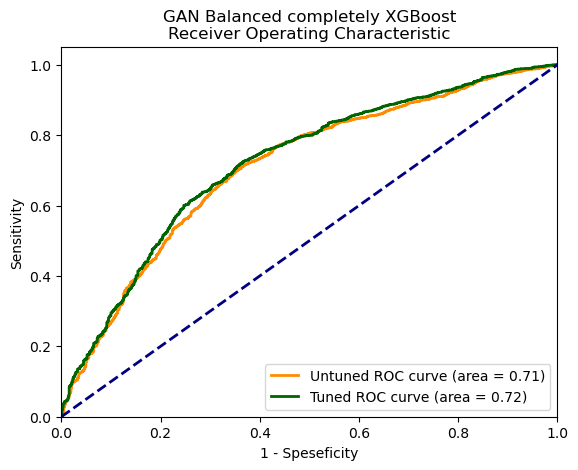

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# AUC curves
base_pred_prob = base_xgb.predict_proba(X_test)[:, 1]
tuned_pred_prob = final_xgb.predict_proba(X_test)[:, 1]
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, base_pred_prob)
roc_auc_baseline = auc(fpr, tpr)

fpr_t, tpr_t, _ = roc_curve(y_test, tuned_pred_prob)
roc_auc_tuned = auc(fpr_t, tpr_t)


# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Untuned ROC curve (area = %0.2f)' % roc_auc_baseline)
plt.plot(fpr_t, tpr_t, color='darkgreen', lw=2, label='Tuned ROC curve (area = %0.2f)' % roc_auc_tuned)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Speseficity')
plt.ylabel('Sensitivity')
plt.title('GAN Balanced completely XGBoost\nReceiver Operating Characteristic')
plt.legend(loc="lower right")

plt.savefig('roc_curve_GAN_fully_balanced.png',format='png', dpi=300,
           transparent=True)

plt.show()

# RF classification tuning with oversampling 

### still needs to add some feature to tune_hyperparameters_rf

0.5426774444797162


  0%|          | 0/200 [00:00<?, ?it/s]

Best value: 0.5678233515291939, Best params: {'n_estimators': 549, 'max_depth': 26, 'min_samples_split': 13, 'min_samples_leaf': 11, 'max_leaf_nodes': 435}
Best value: 0.5678233515291939, Best params: {'n_estimators': 549, 'max_depth': 26, 'min_samples_split': 13, 'min_samples_leaf': 11, 'max_leaf_nodes': 435}
Best value: 0.5678233515291939, Best params: {'n_estimators': 549, 'max_depth': 26, 'min_samples_split': 13, 'min_samples_leaf': 11, 'max_leaf_nodes': 435}
Best value: 0.5678233515291939, Best params: {'n_estimators': 549, 'max_depth': 26, 'min_samples_split': 13, 'min_samples_leaf': 11, 'max_leaf_nodes': 435}
Best value: 0.5678233515291939, Best params: {'n_estimators': 549, 'max_depth': 26, 'min_samples_split': 13, 'min_samples_leaf': 11, 'max_leaf_nodes': 435}
Best value: 0.5678233515291939, Best params: {'n_estimators': 549, 'max_depth': 26, 'min_samples_split': 13, 'min_samples_leaf': 11, 'max_leaf_nodes': 435}
Best value: 0.5678233515291939, Best params: {'n_estimators': 54

Best value: 0.6401463674710125, Best params: {'n_estimators': 577, 'max_depth': 21, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_leaf_nodes': 954}
Best value: 0.6401463674710125, Best params: {'n_estimators': 577, 'max_depth': 21, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_leaf_nodes': 954}
Best value: 0.6401463674710125, Best params: {'n_estimators': 577, 'max_depth': 21, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_leaf_nodes': 954}
Best value: 0.6401463674710125, Best params: {'n_estimators': 577, 'max_depth': 21, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_leaf_nodes': 954}
Best value: 0.6401463674710125, Best params: {'n_estimators': 577, 'max_depth': 21, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_leaf_nodes': 954}
Best value: 0.6401463674710125, Best params: {'n_estimators': 577, 'max_depth': 21, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_leaf_nodes': 954}
Best value: 0.6401463674710125, Best params: {'n_estimators': 577, 'ma

Best value: 0.6606795352659431, Best params: {'n_estimators': 297, 'max_depth': 35, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_leaf_nodes': 952}
Best value: 0.6606795352659431, Best params: {'n_estimators': 297, 'max_depth': 35, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_leaf_nodes': 952}
Best value: 0.6606795352659431, Best params: {'n_estimators': 297, 'max_depth': 35, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_leaf_nodes': 952}
Best value: 0.6606795352659431, Best params: {'n_estimators': 297, 'max_depth': 35, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_leaf_nodes': 952}
Best value: 0.6606795352659431, Best params: {'n_estimators': 297, 'max_depth': 35, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_leaf_nodes': 952}
Best value: 0.6606795352659431, Best params: {'n_estimators': 297, 'max_depth': 35, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_leaf_nodes': 952}
Best value: 0.6606795352659431, Best params: {'n_estimators': 297, 'max_dept

Best value: 0.6606795352659431, Best params: {'n_estimators': 297, 'max_depth': 35, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_leaf_nodes': 952}
Best value: 0.6606795352659431, Best params: {'n_estimators': 297, 'max_depth': 35, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_leaf_nodes': 952}
Best value: 0.6606795352659431, Best params: {'n_estimators': 297, 'max_depth': 35, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_leaf_nodes': 952}
Best value: 0.6606795352659431, Best params: {'n_estimators': 297, 'max_depth': 35, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_leaf_nodes': 952}
Best value: 0.6606795352659431, Best params: {'n_estimators': 297, 'max_depth': 35, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_leaf_nodes': 952}
Best value: 0.6606795352659431, Best params: {'n_estimators': 297, 'max_depth': 35, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_leaf_nodes': 952}
Best value: 0.6606795352659431, Best params: {'n_estimators': 297, 'max_dept

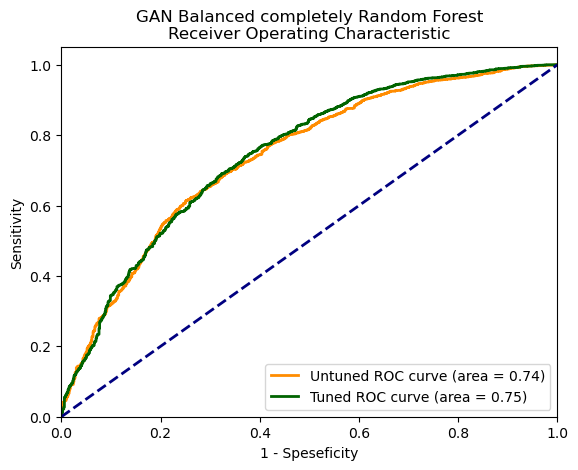

In [186]:
tuned_rf_params, best_rf_score,baseline_score_rf =  Functions_ML_Project.tune_hyperparameters_rf(all_resampled_data,
                                                                                                 eval_metric='balanced_accuracy_score',
                                                                                                 n_trials=200,folds=fold_inx)

# parameters for base model
base_params = {'max_depth':10,
               "n_estimators":100,
               "min_samples_split":5,
               "min_samples_leaf":3,
               "random_state":42,
              "max_features": 'sqrt',
              "criterion":'log_loss',
              }
    

# Applying best parameters to the RandomForestClassifier
final_rf_tuned = RandomForestClassifier(**tuned_rf_params,n_jobs=-1)
base_rf = RandomForestClassifier(**base_params,n_jobs=-1)

final_rf_tuned.fit(X_train, y_train)
base_rf.fit(X_train, y_train)

# Evaluate on test data
tuned_acc_score_rf = balanced_accuracy_score(y_test, final_rf_tuned.predict(X_test))
base_acc_score_rf = balanced_accuracy_score(y_test, base_rf.predict(X_test))
print("Tuned Accuracy Score:", round(tuned_acc_score_rf,3))
print("Base Accuracy Score:", round(base_acc_score_rf,3))
print('Improvemnt of: ',round((tuned_acc_score_rf - base_acc_score_rf),3))


# plot ROC-AUC for random forest result 

# AUC curves
base_pred_prob = base_rf.predict_proba(X_test)[:, 1]
tuned_pred_prob = final_rf_tuned.predict_proba(X_test)[:, 1]
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, base_pred_prob)
roc_auc_baseline = auc(fpr, tpr)

fpr_t, tpr_t, _ = roc_curve(y_test, tuned_pred_prob)
roc_auc_tuned = auc(fpr_t, tpr_t)


# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Untuned ROC curve (area = %0.2f)' % roc_auc_baseline)
plt.plot(fpr_t, tpr_t, color='darkgreen', lw=2, label='Tuned ROC curve (area = %0.2f)' % roc_auc_tuned)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Speseficity')
plt.ylabel('Sensitivity')
plt.title('GAN Balanced completely Random Forest\nReceiver Operating Characteristic')
plt.legend(loc="lower right")

plt.savefig('roc_curve_GAN_fully_balanced_RF.png',format='png', dpi=300,
           transparent=True)

plt.show()

# BalancedRandomForestClassifier for data not oversampled

In [8]:
baseline_score_brf = 0.673
tuned_brf_params = {'n_estimators': 618, 'max_depth': 12,
                    'min_samples_split': 10,
                    'min_samples_leaf': 2, 'max_leaf_nodes': 1171}
best_brf_score =  0.683

In [191]:
tuned_brf_params, best_brf_score,baseline_score_brf =  Functions_ML_Project.tune_hyperparameters_brf(X_train_brf,y_train_brf,5,
                                                                                eval_metric='balanced_accuracy',
                                                                                groupstrat=patient_id,
                                                                                n_trials=100)

0.6733209724114395


  0%|          | 0/100 [00:00<?, ?it/s]

Best value: 0.6825339793597537, Best params: {'n_estimators': 655, 'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_leaf_nodes': 1056}
Best value: 0.682558087495245, Best params: {'n_estimators': 665, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_leaf_nodes': 1046}
Best value: 0.682558087495245, Best params: {'n_estimators': 665, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_leaf_nodes': 1046}
Best value: 0.682558087495245, Best params: {'n_estimators': 665, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_leaf_nodes': 1046}
Best value: 0.682558087495245, Best params: {'n_estimators': 665, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_leaf_nodes': 1046}
Best value: 0.682558087495245, Best params: {'n_estimators': 665, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_leaf_nodes': 1046}
Best value: 0.682558087495245, Best params: {'n_estimators': 665, 'ma

Best value: 0.682558087495245, Best params: {'n_estimators': 665, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_leaf_nodes': 1046}
Best value: 0.682558087495245, Best params: {'n_estimators': 665, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_leaf_nodes': 1046}
Best value: 0.683007191707994, Best params: {'n_estimators': 695, 'max_depth': 12, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_leaf_nodes': 1169}
Best value: 0.683007191707994, Best params: {'n_estimators': 695, 'max_depth': 12, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_leaf_nodes': 1169}
Best value: 0.6832520854380023, Best params: {'n_estimators': 614, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_leaf_nodes': 1110}
Best value: 0.6832520854380023, Best params: {'n_estimators': 614, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_leaf_nodes': 1110}
Best value: 0.6832520854380023, Best params: {'n_estimators': 614, '

NameError: name 'params' is not defined

/home/labs/hornsteinlab/yahelc/.local/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/labs/hornsteinlab/yahelc/.local/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(


Tuned Accuracy Score: 0.689
Base Accuracy Score: 0.686
Improvemnt of:  0.003


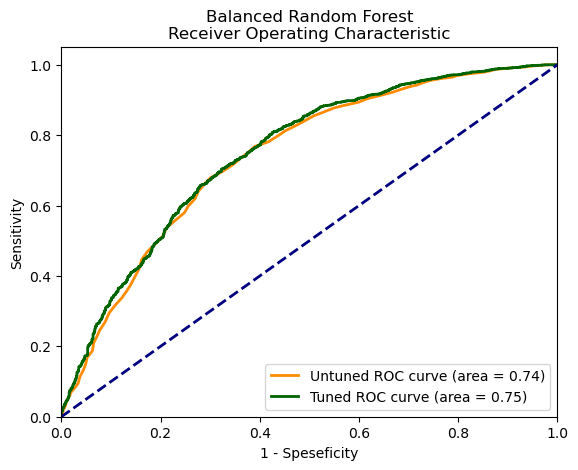

In [10]:
patient_id = training_df_new.patient_nbr[training_df_new.readmitted.isin(['<30', 'NO'])]

# tuned_brf_params, best_brf_score,baseline_score_brf =  Functions_ML_Project.tune_hyperparameters_brf(X_train_brf,y_train_brf,5,
#                                                                                 eval_metric='balanced_accuracy',
#                                                                                 groupstrat=patient_id,
#                                                                                 n_trials=200)

X_train_brf = training_clean_imputed.drop('readmitted', axis =1)
y_train_brf = training_clean_imputed['readmitted']
y_train_brf = LabelEncoder().fit_transform(y_train_brf)


brf_model = BalancedRandomForestClassifier(replacement = True,
                                           bootstrap = True,
                                           random_state=42)

brf_tuned_model = BalancedRandomForestClassifier(**tuned_brf_params,replacement = True,
                                           bootstrap = True,
                                           random_state=42)

brf_model.fit(X_train_brf,y_train_brf)
brf_tuned_model.fit(X_train_brf,y_train_brf)

base_acc_score_brf = balanced_accuracy_score(y_test, brf_model.predict(X_test))
tuned_acc_score_brf = balanced_accuracy_score(y_test, brf_tuned_model.predict(X_test))
print("Tuned Accuracy Score:", round(tuned_acc_score_brf,3))
print("Base Accuracy Score:", round(base_acc_score_brf,3))
print('Improvemnt of: ',round((tuned_acc_score_brf - base_acc_score_brf),3))


# AUC curves
base_pred_prob = brf_model.predict_proba(X_test)[:, 1]
tuned_pred_prob = brf_tuned_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, base_pred_prob)
roc_auc_baseline = auc(fpr, tpr)

fpr_t, tpr_t, _ = roc_curve(y_test, tuned_pred_prob)
roc_auc_tuned = auc(fpr_t, tpr_t)


# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Untuned ROC curve (area = %0.2f)' % roc_auc_baseline)
plt.plot(fpr_t, tpr_t, color='darkgreen', lw=2, label='Tuned ROC curve (area = %0.2f)' % roc_auc_tuned)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Speseficity')
plt.ylabel('Sensitivity')
plt.title('Balanced Random Forest\nReceiver Operating Characteristic')
plt.legend(loc="lower right")

# plt.savefig('roc_curve_unbalanced_BRF.png',format='png', dpi=300,
#            transparent=True)

plt.show()

In [18]:
# Create a SHAP TreeExplainer using the trained model
explainer = shap.TreeExplainer(brf_tuned_model)
# Calculate SHAP values for the test set
shap_values = explainer(X_test)

## features importance using SHAP

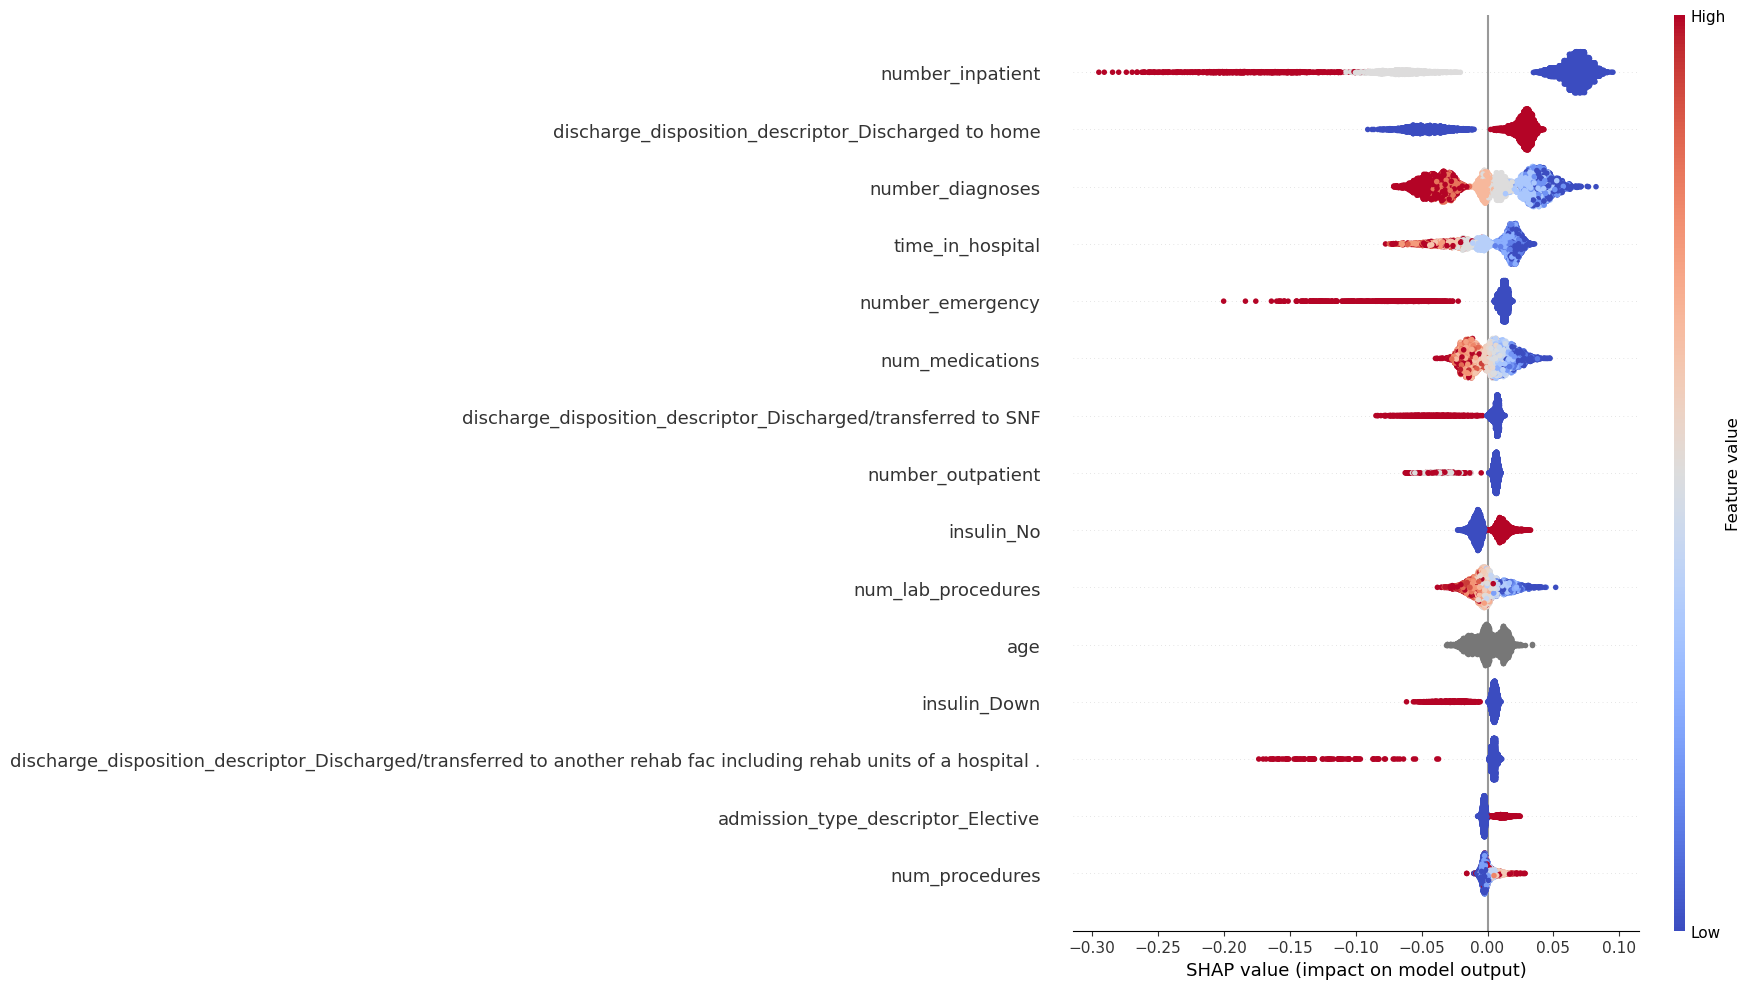

In [68]:
shap.summary_plot(shap_values[:,:,1], X_test, plot_type="dot", max_display=15,plot_size = (18,10),
                 cmap='coolwarm',show = False)

plt.savefig('BRF_SHAP_dotplot.png',format='png', dpi=300,
           transparent=True)


In [74]:
shap.plots.bar(shap_values[:,:,1], max_display=15,show = False)
plt.savefig('BRF_SHAP_barplot.png',format='png', dpi=300,
           transparent=True,bbox_inches='tight')
plt.close()

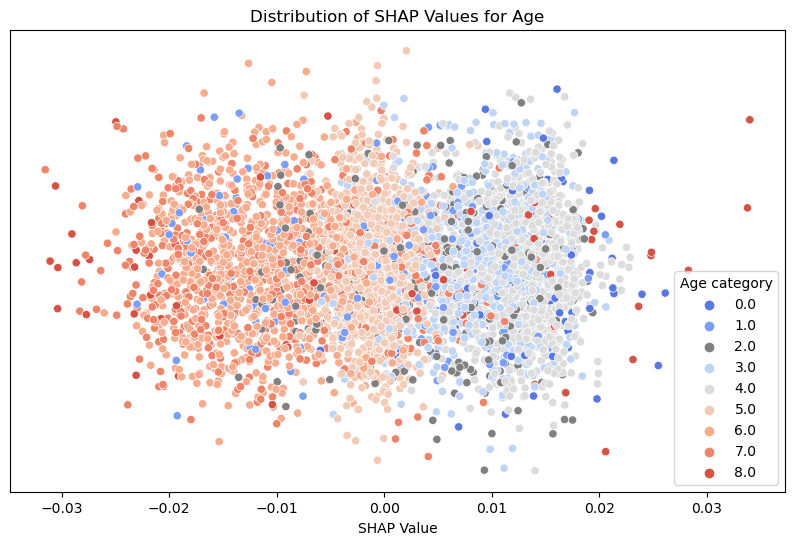

In [62]:
age_shap_values = shap_values[:, X_test.columns.get_loc('age'),1]

colors = sns.color_palette("coolwarm", 9)  # Generate a palette with 9 colors from cool to warm
center_color = ["grey"]  # Center color for the category '4'
full_palette = colors[:2] + center_color + colors[3:]

# Creating a dictionary to map each category to the appropriate color
palette = {i: color for i, color in enumerate(full_palette, start=0)}

# Plot the distribution of SHAP values for 'age'
plt.figure(figsize=(10, 6))
age_shap_df = pd.DataFrame({'Age category':age_shap_values.data,
                           'Shap value' : age_shap_values.values})

sns.scatterplot(age_shap_df,x='Shap value',
                y = np.random.normal(size=len(age_shap_df), scale=0.1,loc=1),
                hue='Age category',
              palette = palette)
plt.title('Distribution of SHAP Values for Age')
plt.xlabel('SHAP Value')
plt.ylabel('')  # Remove y-axis label
plt.yticks([])  # Remove y-axis ticks
plt.gca().axes.yaxis.set_visible(False)  # Hide the y-axis

plt.savefig('BRF_SHAP_dotplot_age.png',format='png', dpi=300,
           transparent=True)
plt.show()


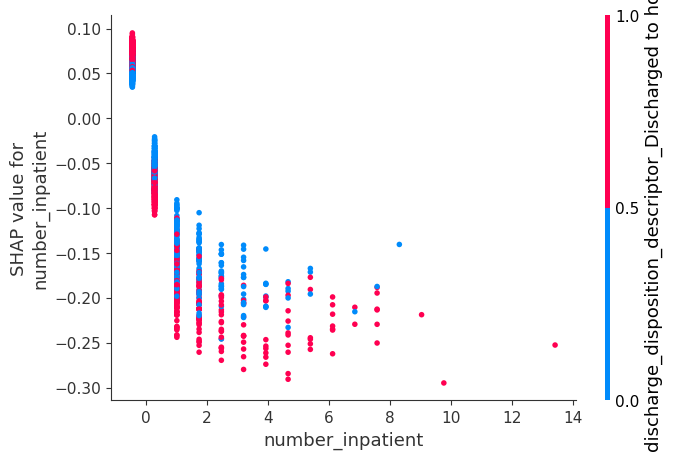

In [55]:
shap.dependence_plot( X_test.columns.get_loc('number_inpatient'), shap_values.values[:,:,1], X_test)

# check stability across different seeds 

In [34]:
seeds_list = [42,1,0,71,10,111,777,710,911,810,8,4,6,13,1948]
scores_lists = []
feature_importance_impurity = pd.DataFrame(columns=X_test.columns)

for seed in seeds_list:
    brf_tuned_model = BalancedRandomForestClassifier(**tuned_brf_params,replacement = True,
                                               bootstrap = True,
                                               random_state=seed)
    
    brf_tuned_model.fit(X_train_brf,y_train_brf)
    feature_importance_impurity.loc[seed] = brf_tuned_model.feature_importances_
    scores_lists.append(balanced_accuracy_score(y_test, brf_tuned_model.predict(X_test)))

ordered_cols = feature_importance_impurity.mean().sort_values(ascending=False).index
feature_importance_impurity = feature_importance_impurity[ordered_cols]

/home/labs/hornsteinlab/yahelc/.local/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/labs/hornsteinlab/yahelc/.local/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/labs/hornsteinlab/yahelc/.local/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Se

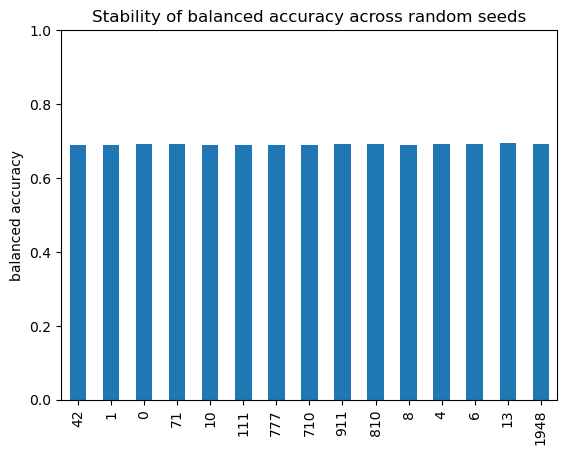

In [40]:
pd.Series(scores_lists, index = feature_importance_impurity.index).plot.bar()
plt.ylim(0,1)
plt.title('Stability of balanced accuracy across random seeds')
plt.ylabel('balanced accuracy')

plt.savefig('BRF_accuracy_across_seeds.png',format='png', dpi=300,
           transparent=True,bbox_inches='tight')

plt.show()

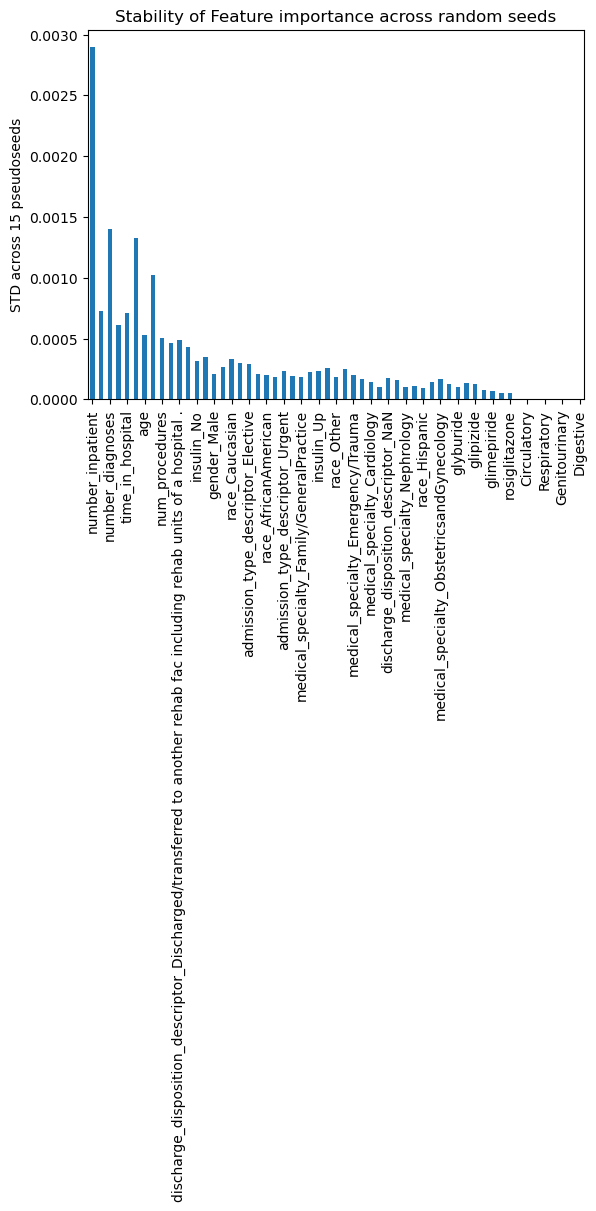

In [32]:
feature_importance_impurity.std().plot.bar()
ax = plt.gca()
plt.title('Stability of Feature importance across random seeds')
plt.ylabel('STD across 15 pseudoseeds')  # Remove y-axis label
ax.set_xticks(ax.get_xticks()[::2])

plt.savefig('BRF_Feature_importance_stability.png',format='png', dpi=300,
           transparent=True,bbox_inches='tight')

plt.show()

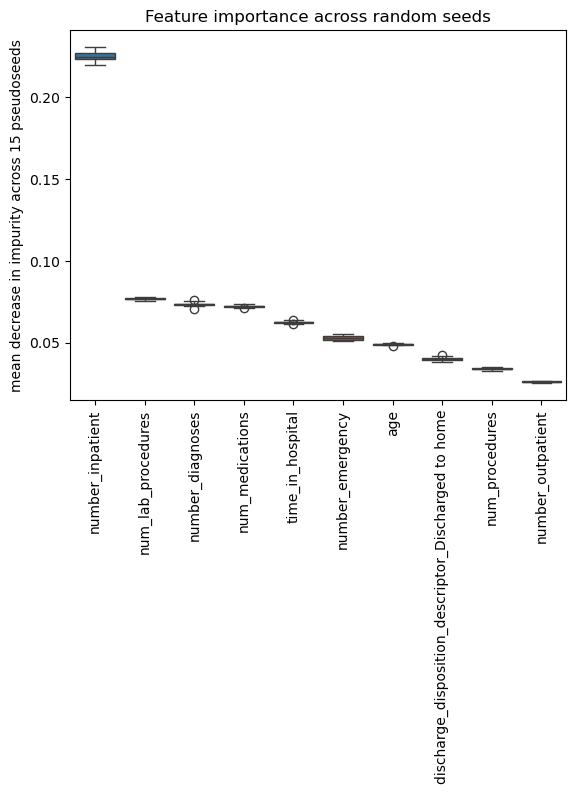

In [53]:
sns.boxplot(data = pd.melt(feature_importance_impurity.iloc[:,:10]),
            x = 'variable', y = 'value',
            hue = 'variable', legend = False)
plt.xticks(rotation=90)

plt.title('Feature importance across random seeds')
plt.ylabel('mean decrease in impurity across 15 pseudoseeds')
plt.xlabel('')
plt.savefig('BRF_top_10_Feature_importance.png',format='png', dpi=300,
           transparent=True,bbox_inches='tight')

plt.show()

In [79]:
path

'default_models_CT_GAN_dataframe.csv'

In [84]:
'original' in path

True

default_models_CT_GAN_dataframe.csv
default_models_COPULA_dataframe.csv
default_models_original_dataframe.csv
default_models_smote_dataframe.csv


/tmp/ipykernel_981/464728618.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90)
/tmp/ipykernel_981/464728618.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90)
/tmp/ipykernel_981/464728618.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90)
/tmp/ipykernel_981/464728618.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90)


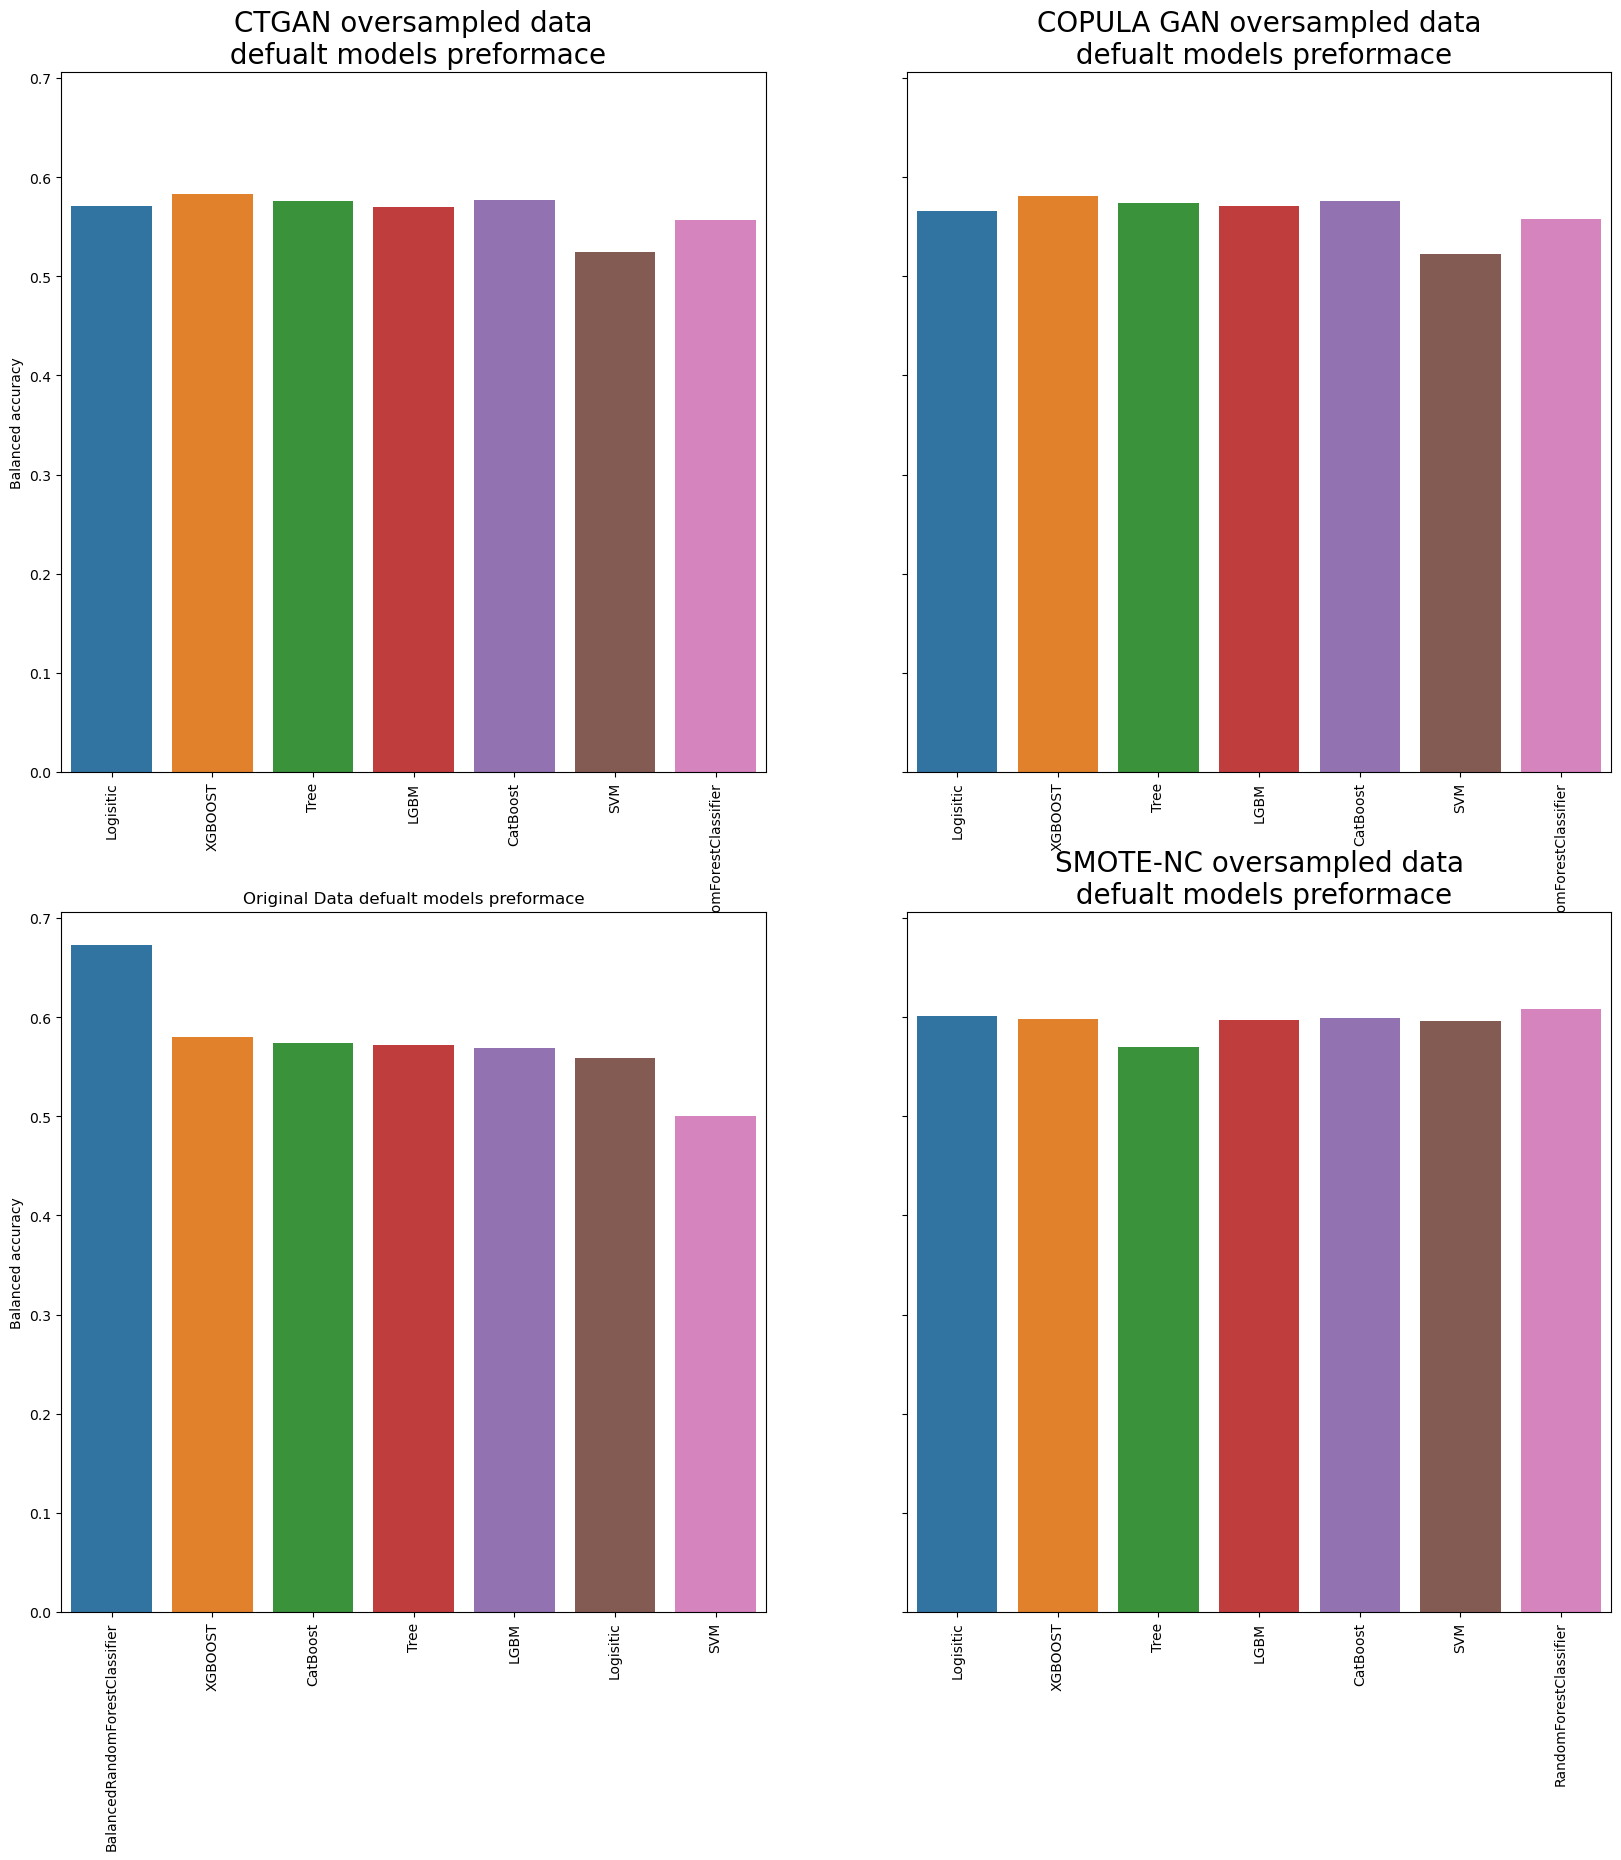

In [97]:
defualt_models_paths = [f for f in os.listdir() if 'default' in f and os.path.isfile(os.path.join(f))]

# Set up the plot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20), sharey=True)
axes = axes.flatten()
for idx, path in enumerate(defualt_models_paths):
    print(path)
    if 'original' in path:
        default_score_df = pd.read_csv(path)
        sns.barplot(default_score_df,y = 'Score', x = 'Model', 
                    hue = 'Model', legend = False,ax=axes[idx])
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90)
        axes[idx].set_title('Original Data defualt models preformace',fontsize = 20)
        axes[idx].set_ylabel('Balanced accuracy',fontsize = 20)
        axes[idx].set_xlabel('')
        continue
    else:
        if 'COPULA' in path:
            default_score_df = pd.read_csv(path)
            plot_title = 'COPULA GAN oversampled data\n defualt models preformace'
        else:
            default_score_df = pd.read_csv(path,index_col=0)
            
            if 'CT' in path:
                plot_title = 'CTGAN oversampled data\n defualt models preformace'
            else:
                plot_title = 'SMOTE-NC oversampled data\n defualt models preformace'
            
        default_score_df = default_score_df.iloc[5,:].reset_index()
        default_score_df.columns = ['Model', 'Score']
        sns.barplot(default_score_df,y = 'Score', x = 'Model',
                        hue = 'Model', legend = False, ax=axes[idx])
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90)
        axes[idx].set_title(plot_title,fontsize = 20)
        axes[idx].set_xlabel('')
        axes[idx].set_ylabel('Balanced accuracy')
